In [1]:
# 0. Pacotes
import pandas as pd
from unicodedata import normalize
from bs4 import BeautifulSoup
import urllib.request
import networkx as nx
import matplotlib.pyplot as plt
import operator

In [2]:
# 1. Dados
df_reembolsos = pd.read_csv("reembolso_4.csv", delimiter = ',')  # junção de tabelas baixadas em http://www2.camara.leg.br/transparencia/cota-para-exercicio-da-atividade-parlamentar/dados-abertos-cota-parlamentar
df_reembolsos = df_reembolsos[df_reembolsos.txtCNPJCPF.notnull()]  # desprezando casos em qISO-8859-1ue o cnpj da empresa é nulo.
df_reembolsos = df_reembolsos[df_reembolsos["numAno"] > 2014]  # focando nos reembolsos a partir de 2015

/home/gustavo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_receitas = pd.read_csv("/home/gustavo/Downloads/Redes/Datasets/receitas_candidatos_2014_brasil .csv", delimiter=';')  # csv baixado em http://www.tse.jus.br/eleicoes/estatisticas/repositorio-de-dados-eleitorais
df_receitas = df_receitas[df_receitas["Cargo"] == "Deputado Federal"] # somente deputados federais

/home/gustavo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# 1.1. Criando dicionário com identificador e nome completo do deputado (será necessário porque a tabecdla de reembolsos não tem o nome completo, só o apelido)
page = urllib.request.urlopen("http://www.camara.leg.br/SitCamaraWS/Deputados.asmx/ObterDeputados")  # link com os dados básicos dos deputados
soup = BeautifulSoup(page, "lxml")
lista_dados_deputados = soup.find_all("deputado")
def remover_acentos(txt):
    return normalize("NFKD", txt).encode("ASCII", "ignore").decode("ASCII")

deputados_dict = {}
for i in range(0,len(lista_dados_deputados)):
    deputados_dict[lista_dados_deputados[i].idecadastro.string] = [remover_acentos(lista_dados_deputados[i].nome.string), lista_dados_deputados[i].urlfoto.string]

In [5]:
# 1.2. Tratamento dos dados
# 1.2.1. Ajustando nomes dos campos
df_reembolsos.columns = ['nome_parlamentar', 'num_agente_politico', 'carteira_parlamentar', 'mandato', 'uf',
                        'partido', 'legislatura', 'sub_cota', 'descricao', 'especificacao_subcota',
                        'descricao_especificacao', 'fornecedor', 'cnpj_cpf_empresa', 'numero_documento_reebolso', 
                         'tipo_documento', 'data_emissao', 'valor_documento', 'valor_glosa', 'valor_liquido',
                        'mes', 'ano', 'parcelado', 'passageiro', 'trecho', 'lote', 'num_ressarcimento', 
                        'vlr_restituicao', 'deputado_id', 'documento_id']

In [6]:
df_receitas.columns = ["seq_candidato", "uf", "sigla_partido", "num_agente_politico", "cargo", 
                       "nome_agente_politico", "cpf_agente_politico", "num_recibo_eleitoral", "num_documento", 
                       "cpf_cnpj_empresa", "nome_empresa", "cod_setor_economico", "nome_setor_economico", 
                       "data_receita", "valor_receita", "tipo_receita", "especie_recurso", "descricao_receita"]

df_receitas['valor_receita'] = df_receitas['valor_receita'].apply(lambda x: float(x.replace(",", ".")))

In [7]:
# 1.2.2. Criando tabelas agregadas
df_reembolso_resumo = df_reembolsos.groupby(['partido', 'uf', 'num_agente_politico', 'fornecedor', 'cnpj_cpf_empresa'
                                            ]).agg({'valor_liquido':['sum','count']}).reset_index()
df_reembolso_resumo.columns = (['partido', 'uf', 'num_agente_politico', 'fornecedor', 'cnpj_cpf_empresa', 
                                'soma_valor_reembolso', 'qtde_reembolsos'])

In [8]:
df_receitas_resumo = df_receitas.groupby(["sigla_partido", "uf", "nome_agente_politico", "nome_empresa", 
                                          "cpf_cnpj_empresa"]).agg({"valor_receita": ['sum', 'count']}).reset_index()
df_receitas_resumo.columns = ["sigla_partido", "uf", "nome_agente_politico", "nome_empresa", 
                              "cpf_cnpj_empresa", "soma_valor_receitas", "qtde_receitas"]

df_receitas_resumo["nome_completo"] = df_receitas_resumo["nome_agente_politico"].map(remover_acentos)

In [9]:
# 1.2.3. Ajuste do Nome dos deputados (na tabela de reembolsos só tem o apelido)
def nome_completo(x):
    if str(int(x)) in list(deputados_dict.keys()):
        y = deputados_dict[str(int(x))][0]
    else:
        y = "sem_info"
    return y

df_reembolso_resumo["nome_completo"] = df_reembolso_resumo["num_agente_politico"].map(nome_completo)
df_reembolso_resumo["num_agente_politico"] = df_reembolso_resumo.num_agente_politico.apply(str)

In [10]:
# 1.2.4. Ajuste do formato do cnpj/cpf dos geradores do reembolso
df_reembolso_resumo["cnpj_cpf_empresa"] = df_reembolso_resumo["cnpj_cpf_empresa"].apply(
lambda x: x.replace("/",""))
df_reembolso_resumo["cnpj_cpf_empresa"] = df_reembolso_resumo["cnpj_cpf_empresa"].apply(
lambda x: x.replace(".",""))
df_reembolso_resumo["cnpj_cpf_empresa"] = df_reembolso_resumo["cnpj_cpf_empresa"].apply(
lambda x: int(x.replace("-","")))
df_reembolso_resumo["cnpj_cpf_empresa"] = df_reembolso_resumo.cnpj_cpf_empresa.apply(int)

In [11]:
# 1.3. Modelando como grafo
# 1.3.1. Criando tabelas de vínculos
df_vinculos_receitas = df_receitas_resumo.iloc[:,3:]
df_vinculos_receitas.columns = ["nome_empresa","id_empresa","valor","qtde", "nome_deputado"]
df_vinculos_receitas["tipo"] = "doacao"

In [12]:
df_vinculos_reembolsos = df_reembolso_resumo.iloc[:,3:]
df_vinculos_reembolsos.columns = ["nome_empresa", "id_empresa", "valor", "qtde", "nome_deputado"]
df_vinculos_reembolsos = df_vinculos_reembolsos[df_vinculos_reembolsos["nome_deputado"] != "sem_info"].reset_index()
df_vinculos_reembolsos["tipo"] = "reembolso"

In [13]:
df_vinculos_agregado = pd.DataFrame()
df_vinculos_agregado["id_entidade_a"] = list(df_vinculos_receitas["id_empresa"]) + list(df_vinculos_reembolsos["nome_deputado"])
df_vinculos_agregado["id_entidade_b"] = list(df_vinculos_receitas["nome_deputado"]) + list(df_vinculos_reembolsos["id_empresa"])
df_vinculos_agregado["tipo"] = list(df_vinculos_receitas["tipo"]) + list(df_vinculos_reembolsos["tipo"])
df_vinculos_agregado["valor"] = list(df_vinculos_receitas["valor"]) + list(df_vinculos_reembolsos["valor"])
df_vinculos_agregado["qtde"] = list(df_vinculos_receitas["qtde"]) + list(df_vinculos_reembolsos["qtde"])
df_vinculos_agregado["nome_empresa"] = list(df_vinculos_receitas["nome_empresa"]) + list(df_vinculos_reembolsos["nome_empresa"])

In [14]:
G = nx.from_pandas_edgelist(df_vinculos_agregado, "id_entidade_a", 'id_entidade_b', ["tipo","valor","qtde"], create_using=nx.DiGraph())
G.nodes()

NodeView((20603438000171, 'FRANCISCO CARLOS OLIVEIRA DE LIMA', 30842735291, 64575365220, 41271882272, 'JOAQUIM LIRA DE CARVALHO', 'JOS AUGUSTO LEANDRO RODRIGUES', 47765933272, 'MARIA SOCORRO SOARES DE OLIVEIRA', 18874894287, '06571832291', 'MARIA TERESA GAUNA', 'NORMANDO RODRIGUES SALES', 1633510000169, 'SAULO DE FREITAS RIBEIRO', 13813013200, 'SEBASTIO ALVES RODRIGUES MANCHINERY', 65919521287, 75461200206, 30856523291, 18541119491, 'EDSON MAIA NOBRE DE ABREU', 20573849000161, '02370669470', 'FLAVIO HENRIQUE CATO NOGUEIRA', 'JOS FRANCISCO DE LIMA', 16436105468, 'MARCOS ANTNIO VIEIRA DA SILVA', 100727000140, 8842442453, '20863691404', '#NULO', 'PAUDERNEY TOMAZ AVELINO', 1666158000168, 22797468000191, 5748909200, 83696628204, 156701200, 33482110263, 43637949253, 5761360187, 4782407000179, 4565289000147, 89979800259, 10238315000125, 33462127268, 4928297000100, 4307088000140, 2887227000126, 5516984000181, 20563951000186, 9257826000105, 14631881291, 38447428249, 37185411220, 5445663000133, 

In [15]:
# agregando atributos aos vértices
dict_nomes = {}
for i in range(0, len(df_vinculos_agregado)):
    if i < len(list(df_vinculos_receitas["nome_empresa"])):
        dict_nomes[df_vinculos_agregado.iloc[i]["id_entidade_a"]] = df_vinculos_agregado.iloc[i]["nome_empresa"]
    else:
        dict_nomes[df_vinculos_agregado.iloc[i]["id_entidade_b"]] = df_vinculos_agregado.iloc[i]["nome_empresa"]
    print(i)

nx.set_node_attributes(G, name='nome_entidade', values=dict_nomes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071


3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722


5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380


6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023


8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694


10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
1030

11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
1166

12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
1304

14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
1443

15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
1580

17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
1719

18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
18554
18555
18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
1858

19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
1996

21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327
21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
2134

22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
22657
22658
22659
22660
22661
22662
22663
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
22682
22683
22684
22685
22686
22687
22688
22689
22690
22691
22692
22693
22694
22695
22696
22697
22698
22699
22700
22701
22702
22703
22704
22705
22706
22707
22708
22709
22710
22711
22712
22713
22714
22715
22716
22717
22718
22719
22720
22721
22722
22723
22724
22725
22726
22727
22728
22729
2273

23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
24099
24100
24101
24102
24103
24104
24105
24106
24107
24108
24109
24110
24111
24112
24113
24114
24115
24116
24117
24118
24119
24120
24121
24122
24123
2412

25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
25424
25425
25426
25427
25428
25429
25430
25431
25432
25433
25434
25435
25436
25437
25438
25439
25440
25441
25442
25443
25444
25445
25446
25447
25448
25449
25450
25451
25452
25453
25454
25455
25456
25457
25458
25459
25460
25461
25462
25463
25464
25465
25466
25467
25468
25469
25470
25471
25472
25473
25474
25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
25487
25488
25489
25490
25491
2549

26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
26799
26800
26801
26802
26803
26804
26805
26806
26807
26808
26809
26810
26811
26812
26813
26814
26815
26816
26817
26818
26819
26820
26821
26822
26823
26824
26825
26826
26827
26828
26829
26830
26831
26832
26833
26834
26835
26836
26837
26838
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848
26849
26850
26851
26852
26853
26854
26855
26856
26857
26858
26859
26860
26861
26862
26863
26864
26865
26866
26867
26868
26869
26870
26871
26872
26873
26874
26875
26876
26877
26878
26879
26880
26881
26882
2688

28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
28177
28178
28179
28180
28181
28182
28183
28184
28185
28186
28187
28188
28189
28190
28191
28192
28193
28194
28195
28196
28197
28198
28199
28200
28201
28202
28203
28204
28205
28206
28207
28208
28209
28210
28211
28212
28213
28214
28215
28216
28217
28218
28219
28220
28221
28222
28223
28224
28225
28226
28227
28228
28229
28230
28231
28232
28233
28234
28235
28236
28237
28238
28239
28240
28241
28242
28243
28244
28245
28246
28247
28248
28249
28250
28251
28252
28253
28254
28255
28256
28257
28258
28259
28260
28261
28262
28263
28264
28265
28266
28267
28268
2826

29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
29553
29554
29555
29556
29557
29558
29559
29560
29561
29562
29563
29564
29565
29566
29567
29568
29569
29570
29571
29572
29573
29574
29575
29576
29577
29578
29579
29580
29581
29582
29583
29584
29585
29586
29587
29588
29589
29590
29591
29592
29593
29594
29595
29596
29597
29598
29599
29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615
29616
29617
29618
29619
29620
29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
29632
29633
29634
29635
29636
29637
29638
29639
29640
29641
29642
29643
29644
29645
29646
29647
29648
29649
29650
29651
29652
29653
29654
29655
29656
2965

30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
30895
30896
30897
30898
30899
30900
30901
30902
30903
30904
30905
30906
30907
30908
30909
30910
30911
30912
30913
30914
30915
30916
30917
30918
30919
30920
30921
30922
30923
30924
30925
30926
30927
30928
30929
30930
30931
30932
30933
30934
30935
30936
30937
30938
30939
30940
30941
30942
30943
30944
30945
30946
30947
30948
30949
30950
30951
30952
30953
30954
30955
30956
30957
30958
30959
30960
30961
30962
30963
30964
30965
30966
30967
30968
30969
30970
30971
30972
30973
30974
30975
30976
30977
30978
30979
30980
30981
30982
30983
30984
30985
30986
30987
30988
30989
30990
30991
30992
30993
30994
30995
30996
30997
30998
30999
31000
31001
31002
31003
31004
31005
31006
31007
31008
31009
31010
31011
31012
31013
31014
31015
31016
31017
31018
31019
31020
31021
31022
31023
31024
31025
31026
31027
31028
31029
31030
31031
31032
31033
31034
31035
31036
31037
31038
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
3104

32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
32295
32296
32297
32298
32299
32300
32301
32302
32303
32304
32305
32306
32307
32308
32309
32310
32311
32312
32313
32314
32315
32316
32317
32318
32319
32320
32321
32322
32323
32324
32325
32326
32327
32328
32329
32330
32331
32332
32333
32334
32335
32336
32337
32338
32339
32340
32341
32342
32343
32344
32345
32346
32347
32348
32349
32350
32351
32352
32353
32354
32355
32356
32357
32358
32359
32360
32361
32362
32363
32364
32365
32366
32367
32368
32369
32370
32371
32372
32373
32374
32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386
32387
32388
32389
32390
32391
32392
32393
32394
32395
32396
32397
32398
32399
32400
32401
32402
32403
32404
32405
32406
32407
32408
32409
32410
32411
32412
32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423
32424
32425
32426
32427
32428
32429
32430
32431
3243

33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686
33687
33688
33689
33690
33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
33714
33715
33716
33717
33718
33719
33720
33721
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739
33740
33741
33742
33743
33744
33745
33746
33747
33748
33749
33750
33751
33752
33753
33754
33755
33756
33757
33758
33759
33760
33761
33762
33763
33764
33765
33766
33767
33768
33769
33770
33771
33772
33773
33774
33775
33776
33777
33778
33779
33780
33781
33782
33783
33784
33785
33786
33787
33788
33789
33790
33791
33792
33793
33794
33795
33796
33797
33798
33799
33800
33801
33802
33803
33804
33805
33806
33807
3380

35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
35056
35057
35058
35059
35060
35061
35062
35063
35064
35065
35066
35067
35068
35069
35070
35071
35072
35073
35074
35075
35076
35077
35078
35079
35080
35081
35082
35083
35084
35085
35086
35087
35088
35089
35090
35091
35092
35093
35094
35095
35096
35097
35098
35099
35100
35101
35102
35103
35104
35105
35106
35107
35108
35109
35110
35111
35112
35113
35114
35115
35116
35117
35118
35119
35120
35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
35136
35137
35138
35139
35140
35141
35142
35143
35144
35145
35146
35147
35148
35149
35150
35151
35152
35153
35154
35155
35156
35157
35158
35159
35160
35161
35162
35163
35164
35165
35166
35167
35168
35169
35170
35171
35172
35173
35174
35175
3517

36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
36440
36441
36442
36443
36444
36445
36446
36447
36448
36449
36450
36451
36452
36453
36454
36455
36456
36457
36458
36459
36460
36461
36462
36463
36464
36465
36466
36467
36468
36469
36470
36471
36472
36473
36474
36475
36476
36477
36478
36479
36480
36481
36482
36483
36484
36485
36486
36487
36488
36489
36490
36491
36492
36493
36494
36495
36496
36497
36498
36499
36500
36501
36502
36503
36504
36505
36506
36507
36508
36509
36510
36511
36512
36513
36514
36515
36516
36517
36518
36519
36520
36521
36522
36523
36524
36525
36526
36527
36528
36529
36530
36531
36532
36533
36534
36535
36536
36537
36538
36539
36540
36541
36542
36543
36544
36545
36546
36547
36548
3654

37780
37781
37782
37783
37784
37785
37786
37787
37788
37789
37790
37791
37792
37793
37794
37795
37796
37797
37798
37799
37800
37801
37802
37803
37804
37805
37806
37807
37808
37809
37810
37811
37812
37813
37814
37815
37816
37817
37818
37819
37820
37821
37822
37823
37824
37825
37826
37827
37828
37829
37830
37831
37832
37833
37834
37835
37836
37837
37838
37839
37840
37841
37842
37843
37844
37845
37846
37847
37848
37849
37850
37851
37852
37853
37854
37855
37856
37857
37858
37859
37860
37861
37862
37863
37864
37865
37866
37867
37868
37869
37870
37871
37872
37873
37874
37875
37876
37877
37878
37879
37880
37881
37882
37883
37884
37885
37886
37887
37888
37889
37890
37891
37892
37893
37894
37895
37896
37897
37898
37899
37900
37901
37902
37903
37904
37905
37906
37907
37908
37909
37910
37911
37912
37913
37914
37915
37916
37917
37918
37919
37920
37921
37922
37923
37924
37925
37926
37927
37928
37929
37930
37931
37932
37933
37934
37935
37936
37937
37938
37939
37940
37941
37942
37943
37944
37945
3794

39156
39157
39158
39159
39160
39161
39162
39163
39164
39165
39166
39167
39168
39169
39170
39171
39172
39173
39174
39175
39176
39177
39178
39179
39180
39181
39182
39183
39184
39185
39186
39187
39188
39189
39190
39191
39192
39193
39194
39195
39196
39197
39198
39199
39200
39201
39202
39203
39204
39205
39206
39207
39208
39209
39210
39211
39212
39213
39214
39215
39216
39217
39218
39219
39220
39221
39222
39223
39224
39225
39226
39227
39228
39229
39230
39231
39232
39233
39234
39235
39236
39237
39238
39239
39240
39241
39242
39243
39244
39245
39246
39247
39248
39249
39250
39251
39252
39253
39254
39255
39256
39257
39258
39259
39260
39261
39262
39263
39264
39265
39266
39267
39268
39269
39270
39271
39272
39273
39274
39275
39276
39277
39278
39279
39280
39281
39282
39283
39284
39285
39286
39287
39288
39289
39290
39291
39292
39293
39294
39295
39296
39297
39298
39299
39300
39301
39302
39303
39304
39305
39306
39307
39308
39309
39310
39311
39312
39313
39314
39315
39316
39317
39318
39319
39320
39321
3932

40531
40532
40533
40534
40535
40536
40537
40538
40539
40540
40541
40542
40543
40544
40545
40546
40547
40548
40549
40550
40551
40552
40553
40554
40555
40556
40557
40558
40559
40560
40561
40562
40563
40564
40565
40566
40567
40568
40569
40570
40571
40572
40573
40574
40575
40576
40577
40578
40579
40580
40581
40582
40583
40584
40585
40586
40587
40588
40589
40590
40591
40592
40593
40594
40595
40596
40597
40598
40599
40600
40601
40602
40603
40604
40605
40606
40607
40608
40609
40610
40611
40612
40613
40614
40615
40616
40617
40618
40619
40620
40621
40622
40623
40624
40625
40626
40627
40628
40629
40630
40631
40632
40633
40634
40635
40636
40637
40638
40639
40640
40641
40642
40643
40644
40645
40646
40647
40648
40649
40650
40651
40652
40653
40654
40655
40656
40657
40658
40659
40660
40661
40662
40663
40664
40665
40666
40667
40668
40669
40670
40671
40672
40673
40674
40675
40676
40677
40678
40679
40680
40681
40682
40683
40684
40685
40686
40687
40688
40689
40690
40691
40692
40693
40694
40695
40696
4069

41918
41919
41920
41921
41922
41923
41924
41925
41926
41927
41928
41929
41930
41931
41932
41933
41934
41935
41936
41937
41938
41939
41940
41941
41942
41943
41944
41945
41946
41947
41948
41949
41950
41951
41952
41953
41954
41955
41956
41957
41958
41959
41960
41961
41962
41963
41964
41965
41966
41967
41968
41969
41970
41971
41972
41973
41974
41975
41976
41977
41978
41979
41980
41981
41982
41983
41984
41985
41986
41987
41988
41989
41990
41991
41992
41993
41994
41995
41996
41997
41998
41999
42000
42001
42002
42003
42004
42005
42006
42007
42008
42009
42010
42011
42012
42013
42014
42015
42016
42017
42018
42019
42020
42021
42022
42023
42024
42025
42026
42027
42028
42029
42030
42031
42032
42033
42034
42035
42036
42037
42038
42039
42040
42041
42042
42043
42044
42045
42046
42047
42048
42049
42050
42051
42052
42053
42054
42055
42056
42057
42058
42059
42060
42061
42062
42063
42064
42065
42066
42067
42068
42069
42070
42071
42072
42073
42074
42075
42076
42077
42078
42079
42080
42081
42082
42083
4208

43293
43294
43295
43296
43297
43298
43299
43300
43301
43302
43303
43304
43305
43306
43307
43308
43309
43310
43311
43312
43313
43314
43315
43316
43317
43318
43319
43320
43321
43322
43323
43324
43325
43326
43327
43328
43329
43330
43331
43332
43333
43334
43335
43336
43337
43338
43339
43340
43341
43342
43343
43344
43345
43346
43347
43348
43349
43350
43351
43352
43353
43354
43355
43356
43357
43358
43359
43360
43361
43362
43363
43364
43365
43366
43367
43368
43369
43370
43371
43372
43373
43374
43375
43376
43377
43378
43379
43380
43381
43382
43383
43384
43385
43386
43387
43388
43389
43390
43391
43392
43393
43394
43395
43396
43397
43398
43399
43400
43401
43402
43403
43404
43405
43406
43407
43408
43409
43410
43411
43412
43413
43414
43415
43416
43417
43418
43419
43420
43421
43422
43423
43424
43425
43426
43427
43428
43429
43430
43431
43432
43433
43434
43435
43436
43437
43438
43439
43440
43441
43442
43443
43444
43445
43446
43447
43448
43449
43450
43451
43452
43453
43454
43455
43456
43457
43458
4345

44693
44694
44695
44696
44697
44698
44699
44700
44701
44702
44703
44704
44705
44706
44707
44708
44709
44710
44711
44712
44713
44714
44715
44716
44717
44718
44719
44720
44721
44722
44723
44724
44725
44726
44727
44728
44729
44730
44731
44732
44733
44734
44735
44736
44737
44738
44739
44740
44741
44742
44743
44744
44745
44746
44747
44748
44749
44750
44751
44752
44753
44754
44755
44756
44757
44758
44759
44760
44761
44762
44763
44764
44765
44766
44767
44768
44769
44770
44771
44772
44773
44774
44775
44776
44777
44778
44779
44780
44781
44782
44783
44784
44785
44786
44787
44788
44789
44790
44791
44792
44793
44794
44795
44796
44797
44798
44799
44800
44801
44802
44803
44804
44805
44806
44807
44808
44809
44810
44811
44812
44813
44814
44815
44816
44817
44818
44819
44820
44821
44822
44823
44824
44825
44826
44827
44828
44829
44830
44831
44832
44833
44834
44835
44836
44837
44838
44839
44840
44841
44842
44843
44844
44845
44846
44847
44848
44849
44850
44851
44852
44853
44854
44855
44856
44857
44858
4485

46070
46071
46072
46073
46074
46075
46076
46077
46078
46079
46080
46081
46082
46083
46084
46085
46086
46087
46088
46089
46090
46091
46092
46093
46094
46095
46096
46097
46098
46099
46100
46101
46102
46103
46104
46105
46106
46107
46108
46109
46110
46111
46112
46113
46114
46115
46116
46117
46118
46119
46120
46121
46122
46123
46124
46125
46126
46127
46128
46129
46130
46131
46132
46133
46134
46135
46136
46137
46138
46139
46140
46141
46142
46143
46144
46145
46146
46147
46148
46149
46150
46151
46152
46153
46154
46155
46156
46157
46158
46159
46160
46161
46162
46163
46164
46165
46166
46167
46168
46169
46170
46171
46172
46173
46174
46175
46176
46177
46178
46179
46180
46181
46182
46183
46184
46185
46186
46187
46188
46189
46190
46191
46192
46193
46194
46195
46196
46197
46198
46199
46200
46201
46202
46203
46204
46205
46206
46207
46208
46209
46210
46211
46212
46213
46214
46215
46216
46217
46218
46219
46220
46221
46222
46223
46224
46225
46226
46227
46228
46229
46230
46231
46232
46233
46234
46235
4623

47456
47457
47458
47459
47460
47461
47462
47463
47464
47465
47466
47467
47468
47469
47470
47471
47472
47473
47474
47475
47476
47477
47478
47479
47480
47481
47482
47483
47484
47485
47486
47487
47488
47489
47490
47491
47492
47493
47494
47495
47496
47497
47498
47499
47500
47501
47502
47503
47504
47505
47506
47507
47508
47509
47510
47511
47512
47513
47514
47515
47516
47517
47518
47519
47520
47521
47522
47523
47524
47525
47526
47527
47528
47529
47530
47531
47532
47533
47534
47535
47536
47537
47538
47539
47540
47541
47542
47543
47544
47545
47546
47547
47548
47549
47550
47551
47552
47553
47554
47555
47556
47557
47558
47559
47560
47561
47562
47563
47564
47565
47566
47567
47568
47569
47570
47571
47572
47573
47574
47575
47576
47577
47578
47579
47580
47581
47582
47583
47584
47585
47586
47587
47588
47589
47590
47591
47592
47593
47594
47595
47596
47597
47598
47599
47600
47601
47602
47603
47604
47605
47606
47607
47608
47609
47610
47611
47612
47613
47614
47615
47616
47617
47618
47619
47620
47621
4762

48848
48849
48850
48851
48852
48853
48854
48855
48856
48857
48858
48859
48860
48861
48862
48863
48864
48865
48866
48867
48868
48869
48870
48871
48872
48873
48874
48875
48876
48877
48878
48879
48880
48881
48882
48883
48884
48885
48886
48887
48888
48889
48890
48891
48892
48893
48894
48895
48896
48897
48898
48899
48900
48901
48902
48903
48904
48905
48906
48907
48908
48909
48910
48911
48912
48913
48914
48915
48916
48917
48918
48919
48920
48921
48922
48923
48924
48925
48926
48927
48928
48929
48930
48931
48932
48933
48934
48935
48936
48937
48938
48939
48940
48941
48942
48943
48944
48945
48946
48947
48948
48949
48950
48951
48952
48953
48954
48955
48956
48957
48958
48959
48960
48961
48962
48963
48964
48965
48966
48967
48968
48969
48970
48971
48972
48973
48974
48975
48976
48977
48978
48979
48980
48981
48982
48983
48984
48985
48986
48987
48988
48989
48990
48991
48992
48993
48994
48995
48996
48997
48998
48999
49000
49001
49002
49003
49004
49005
49006
49007
49008
49009
49010
49011
49012
49013
4901

50221
50222
50223
50224
50225
50226
50227
50228
50229
50230
50231
50232
50233
50234
50235
50236
50237
50238
50239
50240
50241
50242
50243
50244
50245
50246
50247
50248
50249
50250
50251
50252
50253
50254
50255
50256
50257
50258
50259
50260
50261
50262
50263
50264
50265
50266
50267
50268
50269
50270
50271
50272
50273
50274
50275
50276
50277
50278
50279
50280
50281
50282
50283
50284
50285
50286
50287
50288
50289
50290
50291
50292
50293
50294
50295
50296
50297
50298
50299
50300
50301
50302
50303
50304
50305
50306
50307
50308
50309
50310
50311
50312
50313
50314
50315
50316
50317
50318
50319
50320
50321
50322
50323
50324
50325
50326
50327
50328
50329
50330
50331
50332
50333
50334
50335
50336
50337
50338
50339
50340
50341
50342
50343
50344
50345
50346
50347
50348
50349
50350
50351
50352
50353
50354
50355
50356
50357
50358
50359
50360
50361
50362
50363
50364
50365
50366
50367
50368
50369
50370
50371
50372
50373
50374
50375
50376
50377
50378
50379
50380
50381
50382
50383
50384
50385
50386
5038

51609
51610
51611
51612
51613
51614
51615
51616
51617
51618
51619
51620
51621
51622
51623
51624
51625
51626
51627
51628
51629
51630
51631
51632
51633
51634
51635
51636
51637
51638
51639
51640
51641
51642
51643
51644
51645
51646
51647
51648
51649
51650
51651
51652
51653
51654
51655
51656
51657
51658
51659
51660
51661
51662
51663
51664
51665
51666
51667
51668
51669
51670
51671
51672
51673
51674
51675
51676
51677
51678
51679
51680
51681
51682
51683
51684
51685
51686
51687
51688
51689
51690
51691
51692
51693
51694
51695
51696
51697
51698
51699
51700
51701
51702
51703
51704
51705
51706
51707
51708
51709
51710
51711
51712
51713
51714
51715
51716
51717
51718
51719
51720
51721
51722
51723
51724
51725
51726
51727
51728
51729
51730
51731
51732
51733
51734
51735
51736
51737
51738
51739
51740
51741
51742
51743
51744
51745
51746
51747
51748
51749
51750
51751
51752
51753
51754
51755
51756
51757
51758
51759
51760
51761
51762
51763
51764
51765
51766
51767
51768
51769
51770
51771
51772
51773
51774
5177

52982
52983
52984
52985
52986
52987
52988
52989
52990
52991
52992
52993
52994
52995
52996
52997
52998
52999
53000
53001
53002
53003
53004
53005
53006
53007
53008
53009
53010
53011
53012
53013
53014
53015
53016
53017
53018
53019
53020
53021
53022
53023
53024
53025
53026
53027
53028
53029
53030
53031
53032
53033
53034
53035
53036
53037
53038
53039
53040
53041
53042
53043
53044
53045
53046
53047
53048
53049
53050
53051
53052
53053
53054
53055
53056
53057
53058
53059
53060
53061
53062
53063
53064
53065
53066
53067
53068
53069
53070
53071
53072
53073
53074
53075
53076
53077
53078
53079
53080
53081
53082
53083
53084
53085
53086
53087
53088
53089
53090
53091
53092
53093
53094
53095
53096
53097
53098
53099
53100
53101
53102
53103
53104
53105
53106
53107
53108
53109
53110
53111
53112
53113
53114
53115
53116
53117
53118
53119
53120
53121
53122
53123
53124
53125
53126
53127
53128
53129
53130
53131
53132
53133
53134
53135
53136
53137
53138
53139
53140
53141
53142
53143
53144
53145
53146
53147
5314

54357
54358
54359
54360
54361
54362
54363
54364
54365
54366
54367
54368
54369
54370
54371
54372
54373
54374
54375
54376
54377
54378
54379
54380
54381
54382
54383
54384
54385
54386
54387
54388
54389
54390
54391
54392
54393
54394
54395
54396
54397
54398
54399
54400
54401
54402
54403
54404
54405
54406
54407
54408
54409
54410
54411
54412
54413
54414
54415
54416
54417
54418
54419
54420
54421
54422
54423
54424
54425
54426
54427
54428
54429
54430
54431
54432
54433
54434
54435
54436
54437
54438
54439
54440
54441
54442
54443
54444
54445
54446
54447
54448
54449
54450
54451
54452
54453
54454
54455
54456
54457
54458
54459
54460
54461
54462
54463
54464
54465
54466
54467
54468
54469
54470
54471
54472
54473
54474
54475
54476
54477
54478
54479
54480
54481
54482
54483
54484
54485
54486
54487
54488
54489
54490
54491
54492
54493
54494
54495
54496
54497
54498
54499
54500
54501
54502
54503
54504
54505
54506
54507
54508
54509
54510
54511
54512
54513
54514
54515
54516
54517
54518
54519
54520
54521
54522
5452

55749
55750
55751
55752
55753
55754
55755
55756
55757
55758
55759
55760
55761
55762
55763
55764
55765
55766
55767
55768
55769
55770
55771
55772
55773
55774
55775
55776
55777
55778
55779
55780
55781
55782
55783
55784
55785
55786
55787
55788
55789
55790
55791
55792
55793
55794
55795
55796
55797
55798
55799
55800
55801
55802
55803
55804
55805
55806
55807
55808
55809
55810
55811
55812
55813
55814
55815
55816
55817
55818
55819
55820
55821
55822
55823
55824
55825
55826
55827
55828
55829
55830
55831
55832
55833
55834
55835
55836
55837
55838
55839
55840
55841
55842
55843
55844
55845
55846
55847
55848
55849
55850
55851
55852
55853
55854
55855
55856
55857
55858
55859
55860
55861
55862
55863
55864
55865
55866
55867
55868
55869
55870
55871
55872
55873
55874
55875
55876
55877
55878
55879
55880
55881
55882
55883
55884
55885
55886
55887
55888
55889
55890
55891
55892
55893
55894
55895
55896
55897
55898
55899
55900
55901
55902
55903
55904
55905
55906
55907
55908
55909
55910
55911
55912
55913
55914
5591

57135
57136
57137
57138
57139
57140
57141
57142
57143
57144
57145
57146
57147
57148
57149
57150
57151
57152
57153
57154
57155
57156
57157
57158
57159
57160
57161
57162
57163
57164
57165
57166
57167
57168
57169
57170
57171
57172
57173
57174
57175
57176
57177
57178
57179
57180
57181
57182
57183
57184
57185
57186
57187
57188
57189
57190
57191
57192
57193
57194
57195
57196
57197
57198
57199
57200
57201
57202
57203
57204
57205
57206
57207
57208
57209
57210
57211
57212
57213
57214
57215
57216
57217
57218
57219
57220
57221
57222
57223
57224
57225
57226
57227
57228
57229
57230
57231
57232
57233
57234
57235
57236
57237
57238
57239
57240
57241
57242
57243
57244
57245
57246
57247
57248
57249
57250
57251
57252
57253
57254
57255
57256
57257
57258
57259
57260
57261
57262
57263
57264
57265
57266
57267
57268
57269
57270
57271
57272
57273
57274
57275
57276
57277
57278
57279
57280
57281
57282
57283
57284
57285
57286
57287
57288
57289
57290
57291
57292
57293
57294
57295
57296
57297
57298
57299
57300
5730

58533
58534
58535
58536
58537
58538
58539
58540
58541
58542
58543
58544
58545
58546
58547
58548
58549
58550
58551
58552
58553
58554
58555
58556
58557
58558
58559
58560
58561
58562
58563
58564
58565
58566
58567
58568
58569
58570
58571
58572
58573
58574
58575
58576
58577
58578
58579
58580
58581
58582
58583
58584
58585
58586
58587
58588
58589
58590
58591
58592
58593
58594
58595
58596
58597
58598
58599
58600
58601
58602
58603
58604
58605
58606
58607
58608
58609
58610
58611
58612
58613
58614
58615
58616
58617
58618
58619
58620
58621
58622
58623
58624
58625
58626
58627
58628
58629
58630
58631
58632
58633
58634
58635
58636
58637
58638
58639
58640
58641
58642
58643
58644
58645
58646
58647
58648
58649
58650
58651
58652
58653
58654
58655
58656
58657
58658
58659
58660
58661
58662
58663
58664
58665
58666
58667
58668
58669
58670
58671
58672
58673
58674
58675
58676
58677
58678
58679
58680
58681
58682
58683
58684
58685
58686
58687
58688
58689
58690
58691
58692
58693
58694
58695
58696
58697
58698
5869

59907
59908
59909
59910
59911
59912
59913
59914
59915
59916
59917
59918
59919
59920
59921
59922
59923
59924
59925
59926
59927
59928
59929
59930
59931
59932
59933
59934
59935
59936
59937
59938
59939
59940
59941
59942
59943
59944
59945
59946
59947
59948
59949
59950
59951
59952
59953
59954
59955
59956
59957
59958
59959
59960
59961
59962
59963
59964
59965
59966
59967
59968
59969
59970
59971
59972
59973
59974
59975
59976
59977
59978
59979
59980
59981
59982
59983
59984
59985
59986
59987
59988
59989
59990
59991
59992
59993
59994
59995
59996
59997
59998
59999
60000
60001
60002
60003
60004
60005
60006
60007
60008
60009
60010
60011
60012
60013
60014
60015
60016
60017
60018
60019
60020
60021
60022
60023
60024
60025
60026
60027
60028
60029
60030
60031
60032
60033
60034
60035
60036
60037
60038
60039
60040
60041
60042
60043
60044
60045
60046
60047
60048
60049
60050
60051
60052
60053
60054
60055
60056
60057
60058
60059
60060
60061
60062
60063
60064
60065
60066
60067
60068
60069
60070
60071
60072
6007

61278
61279
61280
61281
61282
61283
61284
61285
61286
61287
61288
61289
61290
61291
61292
61293
61294
61295
61296
61297
61298
61299
61300
61301
61302
61303
61304
61305
61306
61307
61308
61309
61310
61311
61312
61313
61314
61315
61316
61317
61318
61319
61320
61321
61322
61323
61324
61325
61326
61327
61328
61329
61330
61331
61332
61333
61334
61335
61336
61337
61338
61339
61340
61341
61342
61343
61344
61345
61346
61347
61348
61349
61350
61351
61352
61353
61354
61355
61356
61357
61358
61359
61360
61361
61362
61363
61364
61365
61366
61367
61368
61369
61370
61371
61372
61373
61374
61375
61376
61377
61378
61379
61380
61381
61382
61383
61384
61385
61386
61387
61388
61389
61390
61391
61392
61393
61394
61395
61396
61397
61398
61399
61400
61401
61402
61403
61404
61405
61406
61407
61408
61409
61410
61411
61412
61413
61414
61415
61416
61417
61418
61419
61420
61421
61422
61423
61424
61425
61426
61427
61428
61429
61430
61431
61432
61433
61434
61435
61436
61437
61438
61439
61440
61441
61442
61443
6144

62672
62673
62674
62675
62676
62677
62678
62679
62680
62681
62682
62683
62684
62685
62686
62687
62688
62689
62690
62691
62692
62693
62694
62695
62696
62697
62698
62699
62700
62701
62702
62703
62704
62705
62706
62707
62708
62709
62710
62711
62712
62713
62714
62715
62716
62717
62718
62719
62720
62721
62722
62723
62724
62725
62726
62727
62728
62729
62730
62731
62732
62733
62734
62735
62736
62737
62738
62739
62740
62741
62742
62743
62744
62745
62746
62747
62748
62749
62750
62751
62752
62753
62754
62755
62756
62757
62758
62759
62760
62761
62762
62763
62764
62765
62766
62767
62768
62769
62770
62771
62772
62773
62774
62775
62776
62777
62778
62779
62780
62781
62782
62783
62784
62785
62786
62787
62788
62789
62790
62791
62792
62793
62794
62795
62796
62797
62798
62799
62800
62801
62802
62803
62804
62805
62806
62807
62808
62809
62810
62811
62812
62813
62814
62815
62816
62817
62818
62819
62820
62821
62822
62823
62824
62825
62826
62827
62828
62829
62830
62831
62832
62833
62834
62835
62836
62837
6283

64056
64057
64058
64059
64060
64061
64062
64063
64064
64065
64066
64067
64068
64069
64070
64071
64072
64073
64074
64075
64076
64077
64078
64079
64080
64081
64082
64083
64084
64085
64086
64087
64088
64089
64090
64091
64092
64093
64094
64095
64096
64097
64098
64099
64100
64101
64102
64103
64104
64105
64106
64107
64108
64109
64110
64111
64112
64113
64114
64115
64116
64117
64118
64119
64120
64121
64122
64123
64124
64125
64126
64127
64128
64129
64130
64131
64132
64133
64134
64135
64136
64137
64138
64139
64140
64141
64142
64143
64144
64145
64146
64147
64148
64149
64150
64151
64152
64153
64154
64155
64156
64157
64158
64159
64160
64161
64162
64163
64164
64165
64166
64167
64168
64169
64170
64171
64172
64173
64174
64175
64176
64177
64178
64179
64180
64181
64182
64183
64184
64185
64186
64187
64188
64189
64190
64191
64192
64193
64194
64195
64196
64197
64198
64199
64200
64201
64202
64203
64204
64205
64206
64207
64208
64209
64210
64211
64212
64213
64214
64215
64216
64217
64218
64219
64220
64221
6422

65450
65451
65452
65453
65454
65455
65456
65457
65458
65459
65460
65461
65462
65463
65464
65465
65466
65467
65468
65469
65470
65471
65472
65473
65474
65475
65476
65477
65478
65479
65480
65481
65482
65483
65484
65485
65486
65487
65488
65489
65490
65491
65492
65493
65494
65495
65496
65497
65498
65499
65500
65501
65502
65503
65504
65505
65506
65507
65508
65509
65510
65511
65512
65513
65514
65515
65516
65517
65518
65519
65520
65521
65522
65523
65524
65525
65526
65527
65528
65529
65530
65531
65532
65533
65534
65535
65536
65537
65538
65539
65540
65541
65542
65543
65544
65545
65546
65547
65548
65549
65550
65551
65552
65553
65554
65555
65556
65557
65558
65559
65560
65561
65562
65563
65564
65565
65566
65567
65568
65569
65570
65571
65572
65573
65574
65575
65576
65577
65578
65579
65580
65581
65582
65583
65584
65585
65586
65587
65588
65589
65590
65591
65592
65593
65594
65595
65596
65597
65598
65599
65600
65601
65602
65603
65604
65605
65606
65607
65608
65609
65610
65611
65612
65613
65614
65615
6561

66826
66827
66828
66829
66830
66831
66832
66833
66834
66835
66836
66837
66838
66839
66840
66841
66842
66843
66844
66845
66846
66847
66848
66849
66850
66851
66852
66853
66854
66855
66856
66857
66858
66859
66860
66861
66862
66863
66864
66865
66866
66867
66868
66869
66870
66871
66872
66873
66874
66875
66876
66877
66878
66879
66880
66881
66882
66883
66884
66885
66886
66887
66888
66889
66890
66891
66892
66893
66894
66895
66896
66897
66898
66899
66900
66901
66902
66903
66904
66905
66906
66907
66908
66909
66910
66911
66912
66913
66914
66915
66916
66917
66918
66919
66920
66921
66922
66923
66924
66925
66926
66927
66928
66929
66930
66931
66932
66933
66934
66935
66936
66937
66938
66939
66940
66941
66942
66943
66944
66945
66946
66947
66948
66949
66950
66951
66952
66953
66954
66955
66956
66957
66958
66959
66960
66961
66962
66963
66964
66965
66966
66967
66968
66969
66970
66971
66972
66973
66974
66975
66976
66977
66978
66979
66980
66981
66982
66983
66984
66985
66986
66987
66988
66989
66990
66991
6699

68211
68212
68213
68214
68215
68216
68217
68218
68219
68220
68221
68222
68223
68224
68225
68226
68227
68228
68229
68230
68231
68232
68233
68234
68235
68236
68237
68238
68239
68240
68241
68242
68243
68244
68245
68246
68247
68248
68249
68250
68251
68252
68253
68254
68255
68256
68257
68258
68259
68260
68261
68262
68263
68264
68265
68266
68267
68268
68269
68270
68271
68272
68273
68274
68275
68276
68277
68278
68279
68280
68281
68282
68283
68284
68285
68286
68287
68288
68289
68290
68291
68292
68293
68294
68295
68296
68297
68298
68299
68300
68301
68302
68303
68304
68305
68306
68307
68308
68309
68310
68311
68312
68313
68314
68315
68316
68317
68318
68319
68320
68321
68322
68323
68324
68325
68326
68327
68328
68329
68330
68331
68332
68333
68334
68335
68336
68337
68338
68339
68340
68341
68342
68343
68344
68345
68346
68347
68348
68349
68350
68351
68352
68353
68354
68355
68356
68357
68358
68359
68360
68361
68362
68363
68364
68365
68366
68367
68368
68369
68370
68371
68372
68373
68374
68375
68376
6837

69581
69582
69583
69584
69585
69586
69587
69588
69589
69590
69591
69592
69593
69594
69595
69596
69597
69598
69599
69600
69601
69602
69603
69604
69605
69606
69607
69608
69609
69610
69611
69612
69613
69614
69615
69616
69617
69618
69619
69620
69621
69622
69623
69624
69625
69626
69627
69628
69629
69630
69631
69632
69633
69634
69635
69636
69637
69638
69639
69640
69641
69642
69643
69644
69645
69646
69647
69648
69649
69650
69651
69652
69653
69654
69655
69656
69657
69658
69659
69660
69661
69662
69663
69664
69665
69666
69667
69668
69669
69670
69671
69672
69673
69674
69675
69676
69677
69678
69679
69680
69681
69682
69683
69684
69685
69686
69687
69688
69689
69690
69691
69692
69693
69694
69695
69696
69697
69698
69699
69700
69701
69702
69703
69704
69705
69706
69707
69708
69709
69710
69711
69712
69713
69714
69715
69716
69717
69718
69719
69720
69721
69722
69723
69724
69725
69726
69727
69728
69729
69730
69731
69732
69733
69734
69735
69736
69737
69738
69739
69740
69741
69742
69743
69744
69745
69746
6974

70959
70960
70961
70962
70963
70964
70965
70966
70967
70968
70969
70970
70971
70972
70973
70974
70975
70976
70977
70978
70979
70980
70981
70982
70983
70984
70985
70986
70987
70988
70989
70990
70991
70992
70993
70994
70995
70996
70997
70998
70999
71000
71001
71002
71003
71004
71005
71006
71007
71008
71009
71010
71011
71012
71013
71014
71015
71016
71017
71018
71019
71020
71021
71022
71023
71024
71025
71026
71027
71028
71029
71030
71031
71032
71033
71034
71035
71036
71037
71038
71039
71040
71041
71042
71043
71044
71045
71046
71047
71048
71049
71050
71051
71052
71053
71054
71055
71056
71057
71058
71059
71060
71061
71062
71063
71064
71065
71066
71067
71068
71069
71070
71071
71072
71073
71074
71075
71076
71077
71078
71079
71080
71081
71082
71083
71084
71085
71086
71087
71088
71089
71090
71091
71092
71093
71094
71095
71096
71097
71098
71099
71100
71101
71102
71103
71104
71105
71106
71107
71108
71109
71110
71111
71112
71113
71114
71115
71116
71117
71118
71119
71120
71121
71122
71123
71124
7112

72352
72353
72354
72355
72356
72357
72358
72359
72360
72361
72362
72363
72364
72365
72366
72367
72368
72369
72370
72371
72372
72373
72374
72375
72376
72377
72378
72379
72380
72381
72382
72383
72384
72385
72386
72387
72388
72389
72390
72391
72392
72393
72394
72395
72396
72397
72398
72399
72400
72401
72402
72403
72404
72405
72406
72407
72408
72409
72410
72411
72412
72413
72414
72415
72416
72417
72418
72419
72420
72421
72422
72423
72424
72425
72426
72427
72428
72429
72430
72431
72432
72433
72434
72435
72436
72437
72438
72439
72440
72441
72442
72443
72444
72445
72446
72447
72448
72449
72450
72451
72452
72453
72454
72455
72456
72457
72458
72459
72460
72461
72462
72463
72464
72465
72466
72467
72468
72469
72470
72471
72472
72473
72474
72475
72476
72477
72478
72479
72480
72481
72482
72483
72484
72485
72486
72487
72488
72489
72490
72491
72492
72493
72494
72495
72496
72497
72498
72499
72500
72501
72502
72503
72504
72505
72506
72507
72508
72509
72510
72511
72512
72513
72514
72515
72516
72517
7251

73726
73727
73728
73729
73730
73731
73732
73733
73734
73735
73736
73737
73738
73739
73740
73741
73742
73743
73744
73745
73746
73747
73748
73749
73750
73751
73752
73753
73754
73755
73756
73757
73758
73759
73760
73761
73762
73763
73764
73765
73766
73767
73768
73769
73770
73771
73772
73773
73774
73775
73776
73777
73778
73779
73780
73781
73782
73783
73784
73785
73786
73787
73788
73789
73790
73791
73792
73793
73794
73795
73796
73797
73798
73799
73800
73801
73802
73803
73804
73805
73806
73807
73808
73809
73810
73811
73812
73813
73814
73815
73816
73817
73818
73819
73820
73821
73822
73823
73824
73825
73826
73827
73828
73829
73830
73831
73832
73833
73834
73835
73836
73837
73838
73839
73840
73841
73842
73843
73844
73845
73846
73847
73848
73849
73850
73851
73852
73853
73854
73855
73856
73857
73858
73859
73860
73861
73862
73863
73864
73865
73866
73867
73868
73869
73870
73871
73872
73873
73874
73875
73876
73877
73878
73879
73880
73881
73882
73883
73884
73885
73886
73887
73888
73889
73890
73891
7389

75118
75119
75120
75121
75122
75123
75124
75125
75126
75127
75128
75129
75130
75131
75132
75133
75134
75135
75136
75137
75138
75139
75140
75141
75142
75143
75144
75145
75146
75147
75148
75149
75150
75151
75152
75153
75154
75155
75156
75157
75158
75159
75160
75161
75162
75163
75164
75165
75166
75167
75168
75169
75170
75171
75172
75173
75174
75175
75176
75177
75178
75179
75180
75181
75182
75183
75184
75185
75186
75187
75188
75189
75190
75191
75192
75193
75194
75195
75196
75197
75198
75199
75200
75201
75202
75203
75204
75205
75206
75207
75208
75209
75210
75211
75212
75213
75214
75215
75216
75217
75218
75219
75220
75221
75222
75223
75224
75225
75226
75227
75228
75229
75230
75231
75232
75233
75234
75235
75236
75237
75238
75239
75240
75241
75242
75243
75244
75245
75246
75247
75248
75249
75250
75251
75252
75253
75254
75255
75256
75257
75258
75259
75260
75261
75262
75263
75264
75265
75266
75267
75268
75269
75270
75271
75272
75273
75274
75275
75276
75277
75278
75279
75280
75281
75282
75283
7528

76493
76494
76495
76496
76497
76498
76499
76500
76501
76502
76503
76504
76505
76506
76507
76508
76509
76510
76511
76512
76513
76514
76515
76516
76517
76518
76519
76520
76521
76522
76523
76524
76525
76526
76527
76528
76529
76530
76531
76532
76533
76534
76535
76536
76537
76538
76539
76540
76541
76542
76543
76544
76545
76546
76547
76548
76549
76550
76551
76552
76553
76554
76555
76556
76557
76558
76559
76560
76561
76562
76563
76564
76565
76566
76567
76568
76569
76570
76571
76572
76573
76574
76575
76576
76577
76578
76579
76580
76581
76582
76583
76584
76585
76586
76587
76588
76589
76590
76591
76592
76593
76594
76595
76596
76597
76598
76599
76600
76601
76602
76603
76604
76605
76606
76607
76608
76609
76610
76611
76612
76613
76614
76615
76616
76617
76618
76619
76620
76621
76622
76623
76624
76625
76626
76627
76628
76629
76630
76631
76632
76633
76634
76635
76636
76637
76638
76639
76640
76641
76642
76643
76644
76645
76646
76647
76648
76649
76650
76651
76652
76653
76654
76655
76656
76657
76658
7665

77859
77860
77861
77862
77863
77864
77865
77866
77867
77868
77869
77870
77871
77872
77873
77874
77875
77876
77877
77878
77879
77880
77881
77882
77883
77884
77885
77886
77887
77888
77889
77890
77891
77892
77893
77894
77895
77896
77897
77898
77899
77900
77901
77902
77903
77904
77905
77906
77907
77908
77909
77910
77911
77912
77913
77914
77915
77916
77917
77918
77919
77920
77921
77922
77923
77924
77925
77926
77927
77928
77929
77930
77931
77932
77933
77934
77935
77936
77937
77938
77939
77940
77941
77942
77943
77944
77945
77946
77947
77948
77949
77950
77951
77952
77953
77954
77955
77956
77957
77958
77959
77960
77961
77962
77963
77964
77965
77966
77967
77968
77969
77970
77971
77972
77973
77974
77975
77976
77977
77978
77979
77980
77981
77982
77983
77984
77985
77986
77987
77988
77989
77990
77991
77992
77993
77994
77995
77996
77997
77998
77999
78000
78001
78002
78003
78004
78005
78006
78007
78008
78009
78010
78011
78012
78013
78014
78015
78016
78017
78018
78019
78020
78021
78022
78023
78024
7802

79242
79243
79244
79245
79246
79247
79248
79249
79250
79251
79252
79253
79254
79255
79256
79257
79258
79259
79260
79261
79262
79263
79264
79265
79266
79267
79268
79269
79270
79271
79272
79273
79274
79275
79276
79277
79278
79279
79280
79281
79282
79283
79284
79285
79286
79287
79288
79289
79290
79291
79292
79293
79294
79295
79296
79297
79298
79299
79300
79301
79302
79303
79304
79305
79306
79307
79308
79309
79310
79311
79312
79313
79314
79315
79316
79317
79318
79319
79320
79321
79322
79323
79324
79325
79326
79327
79328
79329
79330
79331
79332
79333
79334
79335
79336
79337
79338
79339
79340
79341
79342
79343
79344
79345
79346
79347
79348
79349
79350
79351
79352
79353
79354
79355
79356
79357
79358
79359
79360
79361
79362
79363
79364
79365
79366
79367
79368
79369
79370
79371
79372
79373
79374
79375
79376
79377
79378
79379
79380
79381
79382
79383
79384
79385
79386
79387
79388
79389
79390
79391
79392
79393
79394
79395
79396
79397
79398
79399
79400
79401
79402
79403
79404
79405
79406
79407
7940

80626
80627
80628
80629
80630
80631
80632
80633
80634
80635
80636
80637
80638
80639
80640
80641
80642
80643
80644
80645
80646
80647
80648
80649
80650
80651
80652
80653
80654
80655
80656
80657
80658
80659
80660
80661
80662
80663
80664
80665
80666
80667
80668
80669
80670
80671
80672
80673
80674
80675
80676
80677
80678
80679
80680
80681
80682
80683
80684
80685
80686
80687
80688
80689
80690
80691
80692
80693
80694
80695
80696
80697
80698
80699
80700
80701
80702
80703
80704
80705
80706
80707
80708
80709
80710
80711
80712
80713
80714
80715
80716
80717
80718
80719
80720
80721
80722
80723
80724
80725
80726
80727
80728
80729
80730
80731
80732
80733
80734
80735
80736
80737
80738
80739
80740
80741
80742
80743
80744
80745
80746
80747
80748
80749
80750
80751
80752
80753
80754
80755
80756
80757
80758
80759
80760
80761
80762
80763
80764
80765
80766
80767
80768
80769
80770
80771
80772
80773
80774
80775
80776
80777
80778
80779
80780
80781
80782
80783
80784
80785
80786
80787
80788
80789
80790
80791
8079

82023
82024
82025
82026
82027
82028
82029
82030
82031
82032
82033
82034
82035
82036
82037
82038
82039
82040
82041
82042
82043
82044
82045
82046
82047
82048
82049
82050
82051
82052
82053
82054
82055
82056
82057
82058
82059
82060
82061
82062
82063
82064
82065
82066
82067
82068
82069
82070
82071
82072
82073
82074
82075
82076
82077
82078
82079
82080
82081
82082
82083
82084
82085
82086
82087
82088
82089
82090
82091
82092
82093
82094
82095
82096
82097
82098
82099
82100
82101
82102
82103
82104
82105
82106
82107
82108
82109
82110
82111
82112
82113
82114
82115
82116
82117
82118
82119
82120
82121
82122
82123
82124
82125
82126
82127
82128
82129
82130
82131
82132
82133
82134
82135
82136
82137
82138
82139
82140
82141
82142
82143
82144
82145
82146
82147
82148
82149
82150
82151
82152
82153
82154
82155
82156
82157
82158
82159
82160
82161
82162
82163
82164
82165
82166
82167
82168
82169
82170
82171
82172
82173
82174
82175
82176
82177
82178
82179
82180
82181
82182
82183
82184
82185
82186
82187
82188
8218

83405
83406
83407
83408
83409
83410
83411
83412
83413
83414
83415
83416
83417
83418
83419
83420
83421
83422
83423
83424
83425
83426
83427
83428
83429
83430
83431
83432
83433
83434
83435
83436
83437
83438
83439
83440
83441
83442
83443
83444
83445
83446
83447
83448
83449
83450
83451
83452
83453
83454
83455
83456
83457
83458
83459
83460
83461
83462
83463
83464
83465
83466
83467
83468
83469
83470
83471
83472
83473
83474
83475
83476
83477
83478
83479
83480
83481
83482
83483
83484
83485
83486
83487
83488
83489
83490
83491
83492
83493
83494
83495
83496
83497
83498
83499
83500
83501
83502
83503
83504
83505
83506
83507
83508
83509
83510
83511
83512
83513
83514
83515
83516
83517
83518
83519
83520
83521
83522
83523
83524
83525
83526
83527
83528
83529
83530
83531
83532
83533
83534
83535
83536
83537
83538
83539
83540
83541
83542
83543
83544
83545
83546
83547
83548
83549
83550
83551
83552
83553
83554
83555
83556
83557
83558
83559
83560
83561
83562
83563
83564
83565
83566
83567
83568
83569
83570
8357

84771
84772
84773
84774
84775
84776
84777
84778
84779
84780
84781
84782
84783
84784
84785
84786
84787
84788
84789
84790
84791
84792
84793
84794
84795
84796
84797
84798
84799
84800
84801
84802
84803
84804
84805
84806
84807
84808
84809
84810
84811
84812
84813
84814
84815
84816
84817
84818
84819
84820
84821
84822
84823
84824
84825
84826
84827
84828
84829
84830
84831
84832
84833
84834
84835
84836
84837
84838
84839
84840
84841
84842
84843
84844
84845
84846
84847
84848
84849
84850
84851
84852
84853
84854
84855
84856
84857
84858
84859
84860
84861
84862
84863
84864
84865
84866
84867
84868
84869
84870
84871
84872
84873
84874
84875
84876
84877
84878
84879
84880
84881
84882
84883
84884
84885
84886
84887
84888
84889
84890
84891
84892
84893
84894
84895
84896
84897
84898
84899
84900
84901
84902
84903
84904
84905
84906
84907
84908
84909
84910
84911
84912
84913
84914
84915
84916
84917
84918
84919
84920
84921
84922
84923
84924
84925
84926
84927
84928
84929
84930
84931
84932
84933
84934
84935
84936
8493

86142
86143
86144
86145
86146
86147
86148
86149
86150
86151
86152
86153
86154
86155
86156
86157
86158
86159
86160
86161
86162
86163
86164
86165
86166
86167
86168
86169
86170
86171
86172
86173
86174
86175
86176
86177
86178
86179
86180
86181
86182
86183
86184
86185
86186
86187
86188
86189
86190
86191
86192
86193
86194
86195
86196
86197
86198
86199
86200
86201
86202
86203
86204
86205
86206
86207
86208
86209
86210
86211
86212
86213
86214
86215
86216
86217
86218
86219
86220
86221
86222
86223
86224
86225
86226
86227
86228
86229
86230
86231
86232
86233
86234
86235
86236
86237
86238
86239
86240
86241
86242
86243
86244
86245
86246
86247
86248
86249
86250
86251
86252
86253
86254
86255
86256
86257
86258
86259
86260
86261
86262
86263
86264
86265
86266
86267
86268
86269
86270
86271
86272
86273
86274
86275
86276
86277
86278
86279
86280
86281
86282
86283
86284
86285
86286
86287
86288
86289
86290
86291
86292
86293
86294
86295
86296
86297
86298
86299
86300
86301
86302
86303
86304
86305
86306
86307
8630

87514
87515
87516
87517
87518
87519
87520
87521
87522
87523
87524
87525
87526
87527
87528
87529
87530
87531
87532
87533
87534
87535
87536
87537
87538
87539
87540
87541
87542
87543
87544
87545
87546
87547
87548
87549
87550
87551
87552
87553
87554
87555
87556
87557
87558
87559
87560
87561
87562
87563
87564
87565
87566
87567
87568
87569
87570
87571
87572
87573
87574
87575
87576
87577
87578
87579
87580
87581
87582
87583
87584
87585
87586
87587
87588
87589
87590
87591
87592
87593
87594
87595
87596
87597
87598
87599
87600
87601
87602
87603
87604
87605
87606
87607
87608
87609
87610
87611
87612
87613
87614
87615
87616
87617
87618
87619
87620
87621
87622
87623
87624
87625
87626
87627
87628
87629
87630
87631
87632
87633
87634
87635
87636
87637
87638
87639
87640
87641
87642
87643
87644
87645
87646
87647
87648
87649
87650
87651
87652
87653
87654
87655
87656
87657
87658
87659
87660
87661
87662
87663
87664
87665
87666
87667
87668
87669
87670
87671
87672
87673
87674
87675
87676
87677
87678
87679
8768

88912
88913
88914
88915
88916
88917
88918
88919
88920
88921
88922
88923
88924
88925
88926
88927
88928
88929
88930
88931
88932
88933
88934
88935
88936
88937
88938
88939
88940
88941
88942
88943
88944
88945
88946
88947
88948
88949
88950
88951
88952
88953
88954
88955
88956
88957
88958
88959
88960
88961
88962
88963
88964
88965
88966
88967
88968
88969
88970
88971
88972
88973
88974
88975
88976
88977
88978
88979
88980
88981
88982
88983
88984
88985
88986
88987
88988
88989
88990
88991
88992
88993
88994
88995
88996
88997
88998
88999
89000
89001
89002
89003
89004
89005
89006
89007
89008
89009
89010
89011
89012
89013
89014
89015
89016
89017
89018
89019
89020
89021
89022
89023
89024
89025
89026
89027
89028
89029
89030
89031
89032
89033
89034
89035
89036
89037
89038
89039
89040
89041
89042
89043
89044
89045
89046
89047
89048
89049
89050
89051
89052
89053
89054
89055
89056
89057
89058
89059
89060
89061
89062
89063
89064
89065
89066
89067
89068
89069
89070
89071
89072
89073
89074
89075
89076
89077
8907

90300
90301
90302
90303
90304
90305
90306
90307
90308
90309
90310
90311
90312
90313
90314
90315
90316
90317
90318
90319
90320
90321
90322
90323
90324
90325
90326
90327
90328
90329
90330
90331
90332
90333
90334
90335
90336
90337
90338
90339
90340
90341
90342
90343
90344
90345
90346
90347
90348
90349
90350
90351
90352
90353
90354
90355
90356
90357
90358
90359
90360
90361
90362
90363
90364
90365
90366
90367
90368
90369
90370
90371
90372
90373
90374
90375
90376
90377
90378
90379
90380
90381
90382
90383
90384
90385
90386
90387
90388
90389
90390
90391
90392
90393
90394
90395
90396
90397
90398
90399
90400
90401
90402
90403
90404
90405
90406
90407
90408
90409
90410
90411
90412
90413
90414
90415
90416
90417
90418
90419
90420
90421
90422
90423
90424
90425
90426
90427
90428
90429
90430
90431
90432
90433
90434
90435
90436
90437
90438
90439
90440
90441
90442
90443
90444
90445
90446
90447
90448
90449
90450
90451
90452
90453
90454
90455
90456
90457
90458
90459
90460
90461
90462
90463
90464
90465
9046

91679
91680
91681
91682
91683
91684
91685
91686
91687
91688
91689
91690
91691
91692
91693
91694
91695
91696
91697
91698
91699
91700
91701
91702
91703
91704
91705
91706
91707
91708
91709
91710
91711
91712
91713
91714
91715
91716
91717
91718
91719
91720
91721
91722
91723
91724
91725
91726
91727
91728
91729
91730
91731
91732
91733
91734
91735
91736
91737
91738
91739
91740
91741
91742
91743
91744
91745
91746
91747
91748
91749
91750
91751
91752
91753
91754
91755
91756
91757
91758
91759
91760
91761
91762
91763
91764
91765
91766
91767
91768
91769
91770
91771
91772
91773
91774
91775
91776
91777
91778
91779
91780
91781
91782
91783
91784
91785
91786
91787
91788
91789
91790
91791
91792
91793
91794
91795
91796
91797
91798
91799
91800
91801
91802
91803
91804
91805
91806
91807
91808
91809
91810
91811
91812
91813
91814
91815
91816
91817
91818
91819
91820
91821
91822
91823
91824
91825
91826
91827
91828
91829
91830
91831
91832
91833
91834
91835
91836
91837
91838
91839
91840
91841
91842
91843
91844
9184

93064
93065
93066
93067
93068
93069
93070
93071
93072
93073
93074
93075
93076
93077
93078
93079
93080
93081
93082
93083
93084
93085
93086
93087
93088
93089
93090
93091
93092
93093
93094
93095
93096
93097
93098
93099
93100
93101
93102
93103
93104
93105
93106
93107
93108
93109
93110
93111
93112
93113
93114
93115
93116
93117
93118
93119
93120
93121
93122
93123
93124
93125
93126
93127
93128
93129
93130
93131
93132
93133
93134
93135
93136
93137
93138
93139
93140
93141
93142
93143
93144
93145
93146
93147
93148
93149
93150
93151
93152
93153
93154
93155
93156
93157
93158
93159
93160
93161
93162
93163
93164
93165
93166
93167
93168
93169
93170
93171
93172
93173
93174
93175
93176
93177
93178
93179
93180
93181
93182
93183
93184
93185
93186
93187
93188
93189
93190
93191
93192
93193
93194
93195
93196
93197
93198
93199
93200
93201
93202
93203
93204
93205
93206
93207
93208
93209
93210
93211
93212
93213
93214
93215
93216
93217
93218
93219
93220
93221
93222
93223
93224
93225
93226
93227
93228
93229
9323

94439
94440
94441
94442
94443
94444
94445
94446
94447
94448
94449
94450
94451
94452
94453
94454
94455
94456
94457
94458
94459
94460
94461
94462
94463
94464
94465
94466
94467
94468
94469
94470
94471
94472
94473
94474
94475
94476
94477
94478
94479
94480
94481
94482
94483
94484
94485
94486
94487
94488
94489
94490
94491
94492
94493
94494
94495
94496
94497
94498
94499
94500
94501
94502
94503
94504
94505
94506
94507
94508
94509
94510
94511
94512
94513
94514
94515
94516
94517
94518
94519
94520
94521
94522
94523
94524
94525
94526
94527
94528
94529
94530
94531
94532
94533
94534
94535
94536
94537
94538
94539
94540
94541
94542
94543
94544
94545
94546
94547
94548
94549
94550
94551
94552
94553
94554
94555
94556
94557
94558
94559
94560
94561
94562
94563
94564
94565
94566
94567
94568
94569
94570
94571
94572
94573
94574
94575
94576
94577
94578
94579
94580
94581
94582
94583
94584
94585
94586
94587
94588
94589
94590
94591
94592
94593
94594
94595
94596
94597
94598
94599
94600
94601
94602
94603
94604
9460

95823
95824
95825
95826
95827
95828
95829
95830
95831
95832
95833
95834
95835
95836
95837
95838
95839
95840
95841
95842
95843
95844
95845
95846
95847
95848
95849
95850
95851
95852
95853
95854
95855
95856
95857
95858
95859
95860
95861
95862
95863
95864
95865
95866
95867
95868
95869
95870
95871
95872
95873
95874
95875
95876
95877
95878
95879
95880
95881
95882
95883
95884
95885
95886
95887
95888
95889
95890
95891
95892
95893
95894
95895
95896
95897
95898
95899
95900
95901
95902
95903
95904
95905
95906
95907
95908
95909
95910
95911
95912
95913
95914
95915
95916
95917
95918
95919
95920
95921
95922
95923
95924
95925
95926
95927
95928
95929
95930
95931
95932
95933
95934
95935
95936
95937
95938
95939
95940
95941
95942
95943
95944
95945
95946
95947
95948
95949
95950
95951
95952
95953
95954
95955
95956
95957
95958
95959
95960
95961
95962
95963
95964
95965
95966
95967
95968
95969
95970
95971
95972
95973
95974
95975
95976
95977
95978
95979
95980
95981
95982
95983
95984
95985
95986
95987
95988
9598

97201
97202
97203
97204
97205
97206
97207
97208
97209
97210
97211
97212
97213
97214
97215
97216
97217
97218
97219
97220
97221
97222
97223
97224
97225
97226
97227
97228
97229
97230
97231
97232
97233
97234
97235
97236
97237
97238
97239
97240
97241
97242
97243
97244
97245
97246
97247
97248
97249
97250
97251
97252
97253
97254
97255
97256
97257
97258
97259
97260
97261
97262
97263
97264
97265
97266
97267
97268
97269
97270
97271
97272
97273
97274
97275
97276
97277
97278
97279
97280
97281
97282
97283
97284
97285
97286
97287
97288
97289
97290
97291
97292
97293
97294
97295
97296
97297
97298
97299
97300
97301
97302
97303
97304
97305
97306
97307
97308
97309
97310
97311
97312
97313
97314
97315
97316
97317
97318
97319
97320
97321
97322
97323
97324
97325
97326
97327
97328
97329
97330
97331
97332
97333
97334
97335
97336
97337
97338
97339
97340
97341
97342
97343
97344
97345
97346
97347
97348
97349
97350
97351
97352
97353
97354
97355
97356
97357
97358
97359
97360
97361
97362
97363
97364
97365
97366
9736

98594
98595
98596
98597
98598
98599
98600
98601
98602
98603
98604
98605
98606
98607
98608
98609
98610
98611
98612
98613
98614
98615
98616
98617
98618
98619
98620
98621
98622
98623
98624
98625
98626
98627
98628
98629
98630
98631
98632
98633
98634
98635
98636
98637
98638
98639
98640
98641
98642
98643
98644
98645
98646
98647
98648
98649
98650
98651
98652
98653
98654
98655
98656
98657
98658
98659
98660
98661
98662
98663
98664
98665
98666
98667
98668
98669
98670
98671
98672
98673
98674
98675
98676
98677
98678
98679
98680
98681
98682
98683
98684
98685
98686
98687
98688
98689
98690
98691
98692
98693
98694
98695
98696
98697
98698
98699
98700
98701
98702
98703
98704
98705
98706
98707
98708
98709
98710
98711
98712
98713
98714
98715
98716
98717
98718
98719
98720
98721
98722
98723
98724
98725
98726
98727
98728
98729
98730
98731
98732
98733
98734
98735
98736
98737
98738
98739
98740
98741
98742
98743
98744
98745
98746
98747
98748
98749
98750
98751
98752
98753
98754
98755
98756
98757
98758
98759
9876

99967
99968
99969
99970
99971
99972
99973
99974
99975
99976
99977
99978
99979
99980
99981
99982
99983
99984
99985
99986
99987
99988
99989
99990
99991
99992
99993
99994
99995
99996
99997
99998
99999
100000
100001
100002
100003
100004
100005
100006
100007
100008
100009
100010
100011
100012
100013
100014
100015
100016
100017
100018
100019
100020
100021
100022
100023
100024
100025
100026
100027
100028
100029
100030
100031
100032
100033
100034
100035
100036
100037
100038
100039
100040
100041
100042
100043
100044
100045
100046
100047
100048
100049
100050
100051
100052
100053
100054
100055
100056
100057
100058
100059
100060
100061
100062
100063
100064
100065
100066
100067
100068
100069
100070
100071
100072
100073
100074
100075
100076
100077
100078
100079
100080
100081
100082
100083
100084
100085
100086
100087
100088
100089
100090
100091
100092
100093
100094
100095
100096
100097
100098
100099
100100
100101
100102
100103
100104
100105
100106
100107
100108
100109
100110
100111
100112
100113
1001

101169
101170
101171
101172
101173
101174
101175
101176
101177
101178
101179
101180
101181
101182
101183
101184
101185
101186
101187
101188
101189
101190
101191
101192
101193
101194
101195
101196
101197
101198
101199
101200
101201
101202
101203
101204
101205
101206
101207
101208
101209
101210
101211
101212
101213
101214
101215
101216
101217
101218
101219
101220
101221
101222
101223
101224
101225
101226
101227
101228
101229
101230
101231
101232
101233
101234
101235
101236
101237
101238
101239
101240
101241
101242
101243
101244
101245
101246
101247
101248
101249
101250
101251
101252
101253
101254
101255
101256
101257
101258
101259
101260
101261
101262
101263
101264
101265
101266
101267
101268
101269
101270
101271
101272
101273
101274
101275
101276
101277
101278
101279
101280
101281
101282
101283
101284
101285
101286
101287
101288
101289
101290
101291
101292
101293
101294
101295
101296
101297
101298
101299
101300
101301
101302
101303
101304
101305
101306
101307
101308
101309
101310
101311

102351
102352
102353
102354
102355
102356
102357
102358
102359
102360
102361
102362
102363
102364
102365
102366
102367
102368
102369
102370
102371
102372
102373
102374
102375
102376
102377
102378
102379
102380
102381
102382
102383
102384
102385
102386
102387
102388
102389
102390
102391
102392
102393
102394
102395
102396
102397
102398
102399
102400
102401
102402
102403
102404
102405
102406
102407
102408
102409
102410
102411
102412
102413
102414
102415
102416
102417
102418
102419
102420
102421
102422
102423
102424
102425
102426
102427
102428
102429
102430
102431
102432
102433
102434
102435
102436
102437
102438
102439
102440
102441
102442
102443
102444
102445
102446
102447
102448
102449
102450
102451
102452
102453
102454
102455
102456
102457
102458
102459
102460
102461
102462
102463
102464
102465
102466
102467
102468
102469
102470
102471
102472
102473
102474
102475
102476
102477
102478
102479
102480
102481
102482
102483
102484
102485
102486
102487
102488
102489
102490
102491
102492
102493

103548
103549
103550
103551
103552
103553
103554
103555
103556
103557
103558
103559
103560
103561
103562
103563
103564
103565
103566
103567
103568
103569
103570
103571
103572
103573
103574
103575
103576
103577
103578
103579
103580
103581
103582
103583
103584
103585
103586
103587
103588
103589
103590
103591
103592
103593
103594
103595
103596
103597
103598
103599
103600
103601
103602
103603
103604
103605
103606
103607
103608
103609
103610
103611
103612
103613
103614
103615
103616
103617
103618
103619
103620
103621
103622
103623
103624
103625
103626
103627
103628
103629
103630
103631
103632
103633
103634
103635
103636
103637
103638
103639
103640
103641
103642
103643
103644
103645
103646
103647
103648
103649
103650
103651
103652
103653
103654
103655
103656
103657
103658
103659
103660
103661
103662
103663
103664
103665
103666
103667
103668
103669
103670
103671
103672
103673
103674
103675
103676
103677
103678
103679
103680
103681
103682
103683
103684
103685
103686
103687
103688
103689
103690

104746
104747
104748
104749
104750
104751
104752
104753
104754
104755
104756
104757
104758
104759
104760
104761
104762
104763
104764
104765
104766
104767
104768
104769
104770
104771
104772
104773
104774
104775
104776
104777
104778
104779
104780
104781
104782
104783
104784
104785
104786
104787
104788
104789
104790
104791
104792
104793
104794
104795
104796
104797
104798
104799
104800
104801
104802
104803
104804
104805
104806
104807
104808
104809
104810
104811
104812
104813
104814
104815
104816
104817
104818
104819
104820
104821
104822
104823
104824
104825
104826
104827
104828
104829
104830
104831
104832
104833
104834
104835
104836
104837
104838
104839
104840
104841
104842
104843
104844
104845
104846
104847
104848
104849
104850
104851
104852
104853
104854
104855
104856
104857
104858
104859
104860
104861
104862
104863
104864
104865
104866
104867
104868
104869
104870
104871
104872
104873
104874
104875
104876
104877
104878
104879
104880
104881
104882
104883
104884
104885
104886
104887
104888

105924
105925
105926
105927
105928
105929
105930
105931
105932
105933
105934
105935
105936
105937
105938
105939
105940
105941
105942
105943
105944
105945
105946
105947
105948
105949
105950
105951
105952
105953
105954
105955
105956
105957
105958
105959
105960
105961
105962
105963
105964
105965
105966
105967
105968
105969
105970
105971
105972
105973
105974
105975
105976
105977
105978
105979
105980
105981
105982
105983
105984
105985
105986
105987
105988
105989
105990
105991
105992
105993
105994
105995
105996
105997
105998
105999
106000
106001
106002
106003
106004
106005
106006
106007
106008
106009
106010
106011
106012
106013
106014
106015
106016
106017
106018
106019
106020
106021
106022
106023
106024
106025
106026
106027
106028
106029
106030
106031
106032
106033
106034
106035
106036
106037
106038
106039
106040
106041
106042
106043
106044
106045
106046
106047
106048
106049
106050
106051
106052
106053
106054
106055
106056
106057
106058
106059
106060
106061
106062
106063
106064
106065
106066

107122
107123
107124
107125
107126
107127
107128
107129
107130
107131
107132
107133
107134
107135
107136
107137
107138
107139
107140
107141
107142
107143
107144
107145
107146
107147
107148
107149
107150
107151
107152
107153
107154
107155
107156
107157
107158
107159
107160
107161
107162
107163
107164
107165
107166
107167
107168
107169
107170
107171
107172
107173
107174
107175
107176
107177
107178
107179
107180
107181
107182
107183
107184
107185
107186
107187
107188
107189
107190
107191
107192
107193
107194
107195
107196
107197
107198
107199
107200
107201
107202
107203
107204
107205
107206
107207
107208
107209
107210
107211
107212
107213
107214
107215
107216
107217
107218
107219
107220
107221
107222
107223
107224
107225
107226
107227
107228
107229
107230
107231
107232
107233
107234
107235
107236
107237
107238
107239
107240
107241
107242
107243
107244
107245
107246
107247
107248
107249
107250
107251
107252
107253
107254
107255
107256
107257
107258
107259
107260
107261
107262
107263
107264

108304
108305
108306
108307
108308
108309
108310
108311
108312
108313
108314
108315
108316
108317
108318
108319
108320
108321
108322
108323
108324
108325
108326
108327
108328
108329
108330
108331
108332
108333
108334
108335
108336
108337
108338
108339
108340
108341
108342
108343
108344
108345
108346
108347
108348
108349
108350
108351
108352
108353
108354
108355
108356
108357
108358
108359
108360
108361
108362
108363
108364
108365
108366
108367
108368
108369
108370
108371
108372
108373
108374
108375
108376
108377
108378
108379
108380
108381
108382
108383
108384
108385
108386
108387
108388
108389
108390
108391
108392
108393
108394
108395
108396
108397
108398
108399
108400
108401
108402
108403
108404
108405
108406
108407
108408
108409
108410
108411
108412
108413
108414
108415
108416
108417
108418
108419
108420
108421
108422
108423
108424
108425
108426
108427
108428
108429
108430
108431
108432
108433
108434
108435
108436
108437
108438
108439
108440
108441
108442
108443
108444
108445
108446

109490
109491
109492
109493
109494
109495
109496
109497
109498
109499
109500
109501
109502
109503
109504
109505
109506
109507
109508
109509
109510
109511
109512
109513
109514
109515
109516
109517
109518
109519
109520
109521
109522
109523
109524
109525
109526
109527
109528
109529
109530
109531
109532
109533
109534
109535
109536
109537
109538
109539
109540
109541
109542
109543
109544
109545
109546
109547
109548
109549
109550
109551
109552
109553
109554
109555
109556
109557
109558
109559
109560
109561
109562
109563
109564
109565
109566
109567
109568
109569
109570
109571
109572
109573
109574
109575
109576
109577
109578
109579
109580
109581
109582
109583
109584
109585
109586
109587
109588
109589
109590
109591
109592
109593
109594
109595
109596
109597
109598
109599
109600
109601
109602
109603
109604
109605
109606
109607
109608
109609
109610
109611
109612
109613
109614
109615
109616
109617
109618
109619
109620
109621
109622
109623
109624
109625
109626
109627
109628
109629
109630
109631
109632

110674
110675
110676
110677
110678
110679
110680
110681
110682
110683
110684
110685
110686
110687
110688
110689
110690
110691
110692
110693
110694
110695
110696
110697
110698
110699
110700
110701
110702
110703
110704
110705
110706
110707
110708
110709
110710
110711
110712
110713
110714
110715
110716
110717
110718
110719
110720
110721
110722
110723
110724
110725
110726
110727
110728
110729
110730
110731
110732
110733
110734
110735
110736
110737
110738
110739
110740
110741
110742
110743
110744
110745
110746
110747
110748
110749
110750
110751
110752
110753
110754
110755
110756
110757
110758
110759
110760
110761
110762
110763
110764
110765
110766
110767
110768
110769
110770
110771
110772
110773
110774
110775
110776
110777
110778
110779
110780
110781
110782
110783
110784
110785
110786
110787
110788
110789
110790
110791
110792
110793
110794
110795
110796
110797
110798
110799
110800
110801
110802
110803
110804
110805
110806
110807
110808
110809
110810
110811
110812
110813
110814
110815
110816

111856
111857
111858
111859
111860
111861
111862
111863
111864
111865
111866
111867
111868
111869
111870
111871
111872
111873
111874
111875
111876
111877
111878
111879
111880
111881
111882
111883
111884
111885
111886
111887
111888
111889
111890
111891
111892
111893
111894
111895
111896
111897
111898
111899
111900
111901
111902
111903
111904
111905
111906
111907
111908
111909
111910
111911
111912
111913
111914
111915
111916
111917
111918
111919
111920
111921
111922
111923
111924
111925
111926
111927
111928
111929
111930
111931
111932
111933
111934
111935
111936
111937
111938
111939
111940
111941
111942
111943
111944
111945
111946
111947
111948
111949
111950
111951
111952
111953
111954
111955
111956
111957
111958
111959
111960
111961
111962
111963
111964
111965
111966
111967
111968
111969
111970
111971
111972
111973
111974
111975
111976
111977
111978
111979
111980
111981
111982
111983
111984
111985
111986
111987
111988
111989
111990
111991
111992
111993
111994
111995
111996
111997
111998

113034
113035
113036
113037
113038
113039
113040
113041
113042
113043
113044
113045
113046
113047
113048
113049
113050
113051
113052
113053
113054
113055
113056
113057
113058
113059
113060
113061
113062
113063
113064
113065
113066
113067
113068
113069
113070
113071
113072
113073
113074
113075
113076
113077
113078
113079
113080
113081
113082
113083
113084
113085
113086
113087
113088
113089
113090
113091
113092
113093
113094
113095
113096
113097
113098
113099
113100
113101
113102
113103
113104
113105
113106
113107
113108
113109
113110
113111
113112
113113
113114
113115
113116
113117
113118
113119
113120
113121
113122
113123
113124
113125
113126
113127
113128
113129
113130
113131
113132
113133
113134
113135
113136
113137
113138
113139
113140
113141
113142
113143
113144
113145
113146
113147
113148
113149
113150
113151
113152
113153
113154
113155
113156
113157
113158
113159
113160
113161
113162
113163
113164
113165
113166
113167
113168
113169
113170
113171
113172
113173
113174
113175
113176

114205
114206
114207
114208
114209
114210
114211
114212
114213
114214
114215
114216
114217
114218
114219
114220
114221
114222
114223
114224
114225
114226
114227
114228
114229
114230
114231
114232
114233
114234
114235
114236
114237
114238
114239
114240
114241
114242
114243
114244
114245
114246
114247
114248
114249
114250
114251
114252
114253
114254
114255
114256
114257
114258
114259
114260
114261
114262
114263
114264
114265
114266
114267
114268
114269
114270
114271
114272
114273
114274
114275
114276
114277
114278
114279
114280
114281
114282
114283
114284
114285
114286
114287
114288
114289
114290
114291
114292
114293
114294
114295
114296
114297
114298
114299
114300
114301
114302
114303
114304
114305
114306
114307
114308
114309
114310
114311
114312
114313
114314
114315
114316
114317
114318
114319
114320
114321
114322
114323
114324
114325
114326
114327
114328
114329
114330
114331
114332
114333
114334
114335
114336
114337
114338
114339
114340
114341
114342
114343
114344
114345
114346
114347

115384
115385
115386
115387
115388
115389
115390
115391
115392
115393
115394
115395
115396
115397
115398
115399
115400
115401
115402
115403
115404
115405
115406
115407
115408
115409
115410
115411
115412
115413
115414
115415
115416
115417
115418
115419
115420
115421
115422
115423
115424
115425
115426
115427
115428
115429
115430
115431
115432
115433
115434
115435
115436
115437
115438
115439
115440
115441
115442
115443
115444
115445
115446
115447
115448
115449
115450
115451
115452
115453
115454
115455
115456
115457
115458
115459
115460
115461
115462
115463
115464
115465
115466
115467
115468
115469
115470
115471
115472
115473
115474
115475
115476
115477
115478
115479
115480
115481
115482
115483
115484
115485
115486
115487
115488
115489
115490
115491
115492
115493
115494
115495
115496
115497
115498
115499
115500
115501
115502
115503
115504
115505
115506
115507
115508
115509
115510
115511
115512
115513
115514
115515
115516
115517
115518
115519
115520
115521
115522
115523
115524
115525
115526

116555
116556
116557
116558
116559
116560
116561
116562
116563
116564
116565
116566
116567
116568
116569
116570
116571
116572
116573
116574
116575
116576
116577
116578
116579
116580
116581
116582
116583
116584
116585
116586
116587
116588
116589
116590
116591
116592
116593
116594
116595
116596
116597
116598
116599
116600
116601
116602
116603
116604
116605
116606
116607
116608
116609
116610
116611
116612
116613
116614
116615
116616
116617
116618
116619
116620
116621
116622
116623
116624
116625
116626
116627
116628
116629
116630
116631
116632
116633
116634
116635
116636
116637
116638
116639
116640
116641
116642
116643
116644
116645
116646
116647
116648
116649
116650
116651
116652
116653
116654
116655
116656
116657
116658
116659
116660
116661
116662
116663
116664
116665
116666
116667
116668
116669
116670
116671
116672
116673
116674
116675
116676
116677
116678
116679
116680
116681
116682
116683
116684
116685
116686
116687
116688
116689
116690
116691
116692
116693
116694
116695
116696
116697

117732
117733
117734
117735
117736
117737
117738
117739
117740
117741
117742
117743
117744
117745
117746
117747
117748
117749
117750
117751
117752
117753
117754
117755
117756
117757
117758
117759
117760
117761
117762
117763
117764
117765
117766
117767
117768
117769
117770
117771
117772
117773
117774
117775
117776
117777
117778
117779
117780
117781
117782
117783
117784
117785
117786
117787
117788
117789
117790
117791
117792
117793
117794
117795
117796
117797
117798
117799
117800
117801
117802
117803
117804
117805
117806
117807
117808
117809
117810
117811
117812
117813
117814
117815
117816
117817
117818
117819
117820
117821
117822
117823
117824
117825
117826
117827
117828
117829
117830
117831
117832
117833
117834
117835
117836
117837
117838
117839
117840
117841
117842
117843
117844
117845
117846
117847
117848
117849
117850
117851
117852
117853
117854
117855
117856
117857
117858
117859
117860
117861
117862
117863
117864
117865
117866
117867
117868
117869
117870
117871
117872
117873
117874

118904
118905
118906
118907
118908
118909
118910
118911
118912
118913
118914
118915
118916
118917
118918
118919
118920
118921
118922
118923
118924
118925
118926
118927
118928
118929
118930
118931
118932
118933
118934
118935
118936
118937
118938
118939
118940
118941
118942
118943
118944
118945
118946
118947
118948
118949
118950
118951
118952
118953
118954
118955
118956
118957
118958
118959
118960
118961
118962
118963
118964
118965
118966
118967
118968
118969
118970
118971
118972
118973
118974
118975
118976
118977
118978
118979
118980
118981
118982
118983
118984
118985
118986
118987
118988
118989
118990
118991
118992
118993
118994
118995
118996
118997
118998
118999
119000
119001
119002
119003
119004
119005
119006
119007
119008
119009
119010
119011
119012
119013
119014
119015
119016
119017
119018
119019
119020
119021
119022
119023
119024
119025
119026
119027
119028
119029
119030
119031
119032
119033
119034
119035
119036
119037
119038
119039
119040
119041
119042
119043
119044
119045
119046

120079
120080
120081
120082
120083
120084
120085
120086
120087
120088
120089
120090
120091
120092
120093
120094
120095
120096
120097
120098
120099
120100
120101
120102
120103
120104
120105
120106
120107
120108
120109
120110
120111
120112
120113
120114
120115
120116
120117
120118
120119
120120
120121
120122
120123
120124
120125
120126
120127
120128
120129
120130
120131
120132
120133
120134
120135
120136
120137
120138
120139
120140
120141
120142
120143
120144
120145
120146
120147
120148
120149
120150
120151
120152
120153
120154
120155
120156
120157
120158
120159
120160
120161
120162
120163
120164
120165
120166
120167
120168
120169
120170
120171
120172
120173
120174
120175
120176
120177
120178
120179
120180
120181
120182
120183
120184
120185
120186
120187
120188
120189
120190
120191
120192
120193
120194
120195
120196
120197
120198
120199
120200
120201
120202
120203
120204
120205
120206
120207
120208
120209
120210
120211
120212
120213
120214
120215
120216
120217
120218
120219
120220
120221

121259
121260
121261
121262
121263
121264
121265
121266
121267
121268
121269
121270
121271
121272
121273
121274
121275
121276
121277
121278
121279
121280
121281
121282
121283
121284
121285
121286
121287
121288
121289
121290
121291
121292
121293
121294
121295
121296
121297
121298
121299
121300
121301
121302
121303
121304
121305
121306
121307
121308
121309
121310
121311
121312
121313
121314
121315
121316
121317
121318
121319
121320
121321
121322
121323
121324
121325
121326
121327
121328
121329
121330
121331
121332
121333
121334
121335
121336
121337
121338
121339
121340
121341
121342
121343
121344
121345
121346
121347
121348
121349
121350
121351
121352
121353
121354
121355
121356
121357
121358
121359
121360
121361
121362
121363
121364
121365
121366
121367
121368
121369
121370
121371
121372
121373
121374
121375
121376
121377
121378
121379
121380
121381
121382
121383
121384
121385
121386
121387
121388
121389
121390
121391
121392
121393
121394
121395
121396
121397
121398
121399
121400
121401

122430
122431
122432
122433
122434
122435
122436
122437
122438
122439
122440
122441
122442
122443
122444
122445
122446
122447
122448
122449
122450
122451
122452
122453
122454
122455
122456
122457
122458
122459
122460
122461
122462
122463
122464
122465
122466
122467
122468
122469
122470
122471
122472
122473
122474
122475
122476
122477
122478
122479
122480
122481
122482
122483
122484
122485
122486
122487
122488
122489
122490
122491
122492
122493
122494
122495
122496
122497
122498
122499
122500
122501
122502
122503
122504
122505
122506
122507
122508
122509
122510
122511
122512
122513
122514
122515
122516
122517
122518
122519
122520
122521
122522
122523
122524
122525
122526
122527
122528
122529
122530
122531
122532
122533
122534
122535
122536
122537
122538
122539
122540
122541
122542
122543
122544
122545
122546
122547
122548
122549
122550
122551
122552
122553
122554
122555
122556
122557
122558
122559
122560
122561
122562
122563
122564
122565
122566
122567
122568
122569
122570
122571
122572

123617
123618
123619
123620
123621
123622
123623
123624
123625
123626
123627
123628
123629
123630
123631
123632
123633
123634
123635
123636
123637
123638
123639
123640
123641
123642
123643
123644
123645
123646
123647
123648
123649
123650
123651
123652
123653
123654
123655
123656
123657
123658
123659
123660
123661
123662
123663
123664
123665
123666
123667
123668
123669
123670
123671
123672
123673
123674
123675
123676
123677
123678
123679
123680
123681
123682
123683
123684
123685
123686
123687
123688
123689
123690
123691
123692
123693
123694
123695
123696
123697
123698
123699
123700
123701
123702
123703
123704
123705
123706
123707
123708
123709
123710
123711
123712
123713
123714
123715
123716
123717
123718
123719
123720
123721
123722
123723
123724
123725
123726
123727
123728
123729
123730
123731
123732
123733
123734
123735
123736
123737
123738
123739
123740
123741
123742
123743
123744
123745
123746
123747
123748
123749
123750
123751
123752
123753
123754
123755
123756
123757
123758
123759

124810
124811
124812
124813
124814
124815
124816
124817
124818
124819
124820
124821
124822
124823
124824
124825
124826
124827
124828
124829
124830
124831
124832
124833
124834
124835
124836
124837
124838
124839
124840
124841
124842
124843
124844
124845
124846
124847
124848
124849
124850
124851
124852
124853
124854
124855
124856
124857
124858
124859
124860
124861
124862
124863
124864
124865
124866
124867
124868
124869
124870
124871
124872
124873
124874
124875
124876
124877
124878
124879
124880
124881
124882
124883
124884
124885
124886
124887
124888
124889
124890
124891
124892
124893
124894
124895
124896
124897
124898
124899
124900
124901
124902
124903
124904
124905
124906
124907
124908
124909
124910
124911
124912
124913
124914
124915
124916
124917
124918
124919
124920
124921
124922
124923
124924
124925
124926
124927
124928
124929
124930
124931
124932
124933
124934
124935
124936
124937
124938
124939
124940
124941
124942
124943
124944
124945
124946
124947
124948
124949
124950
124951
124952

125997
125998
125999
126000
126001
126002
126003
126004
126005
126006
126007
126008
126009
126010
126011
126012
126013
126014
126015
126016
126017
126018
126019
126020
126021
126022
126023
126024
126025
126026
126027
126028
126029
126030
126031
126032
126033
126034
126035
126036
126037
126038
126039
126040
126041
126042
126043
126044
126045
126046
126047
126048
126049
126050
126051
126052
126053
126054
126055
126056
126057
126058
126059
126060
126061
126062
126063
126064
126065
126066
126067
126068
126069
126070
126071
126072
126073
126074
126075
126076
126077
126078
126079
126080
126081
126082
126083
126084
126085
126086
126087
126088
126089
126090
126091
126092
126093
126094
126095
126096
126097
126098
126099
126100
126101
126102
126103
126104
126105
126106
126107
126108
126109
126110
126111
126112
126113
126114
126115
126116
126117
126118
126119
126120
126121
126122
126123
126124
126125
126126
126127
126128
126129
126130
126131
126132
126133
126134
126135
126136
126137
126138
126139

127178
127179
127180
127181
127182
127183
127184
127185
127186
127187
127188
127189
127190
127191
127192
127193
127194
127195
127196
127197
127198
127199
127200
127201
127202
127203
127204
127205
127206
127207
127208
127209
127210
127211
127212
127213
127214
127215
127216
127217
127218
127219
127220
127221
127222
127223
127224
127225
127226
127227
127228
127229
127230
127231
127232
127233
127234
127235
127236
127237
127238
127239
127240
127241
127242
127243
127244
127245
127246
127247
127248
127249
127250
127251
127252
127253
127254
127255
127256
127257
127258
127259
127260
127261
127262
127263
127264
127265
127266
127267
127268
127269
127270
127271
127272
127273
127274
127275
127276
127277
127278
127279
127280
127281
127282
127283
127284
127285
127286
127287
127288
127289
127290
127291
127292
127293
127294
127295
127296
127297
127298
127299
127300
127301
127302
127303
127304
127305
127306
127307
127308
127309
127310
127311
127312
127313
127314
127315
127316
127317
127318
127319
127320

128371
128372
128373
128374
128375
128376
128377
128378
128379
128380
128381
128382
128383
128384
128385
128386
128387
128388
128389
128390
128391
128392
128393
128394
128395
128396
128397
128398
128399
128400
128401
128402
128403
128404
128405
128406
128407
128408
128409
128410
128411
128412
128413
128414
128415
128416
128417
128418
128419
128420
128421
128422
128423
128424
128425
128426
128427
128428
128429
128430
128431
128432
128433
128434
128435
128436
128437
128438
128439
128440
128441
128442
128443
128444
128445
128446
128447
128448
128449
128450
128451
128452
128453
128454
128455
128456
128457
128458
128459
128460
128461
128462
128463
128464
128465
128466
128467
128468
128469
128470
128471
128472
128473
128474
128475
128476
128477
128478
128479
128480
128481
128482
128483
128484
128485
128486
128487
128488
128489
128490
128491
128492
128493
128494
128495
128496
128497
128498
128499
128500
128501
128502
128503
128504
128505
128506
128507
128508
128509
128510
128511
128512
128513

129545
129546
129547
129548
129549
129550
129551
129552
129553
129554
129555
129556
129557
129558
129559
129560
129561
129562
129563
129564
129565
129566
129567
129568
129569
129570
129571
129572
129573
129574
129575
129576
129577
129578
129579
129580
129581
129582
129583
129584
129585
129586
129587
129588
129589
129590
129591
129592
129593
129594
129595
129596
129597
129598
129599
129600
129601
129602
129603
129604
129605
129606
129607
129608
129609
129610
129611
129612
129613
129614
129615
129616
129617
129618
129619
129620
129621
129622
129623
129624
129625
129626
129627
129628
129629
129630
129631
129632
129633
129634
129635
129636
129637
129638
129639
129640
129641
129642
129643
129644
129645
129646
129647
129648
129649
129650
129651
129652
129653
129654
129655
129656
129657
129658
129659
129660
129661
129662
129663
129664
129665
129666
129667
129668
129669
129670
129671
129672
129673
129674
129675
129676
129677
129678
129679
129680
129681
129682
129683
129684
129685
129686
129687

130718
130719
130720
130721
130722
130723
130724
130725
130726
130727
130728
130729
130730
130731
130732
130733
130734
130735
130736
130737
130738
130739
130740
130741
130742
130743
130744
130745
130746
130747
130748
130749
130750
130751
130752
130753
130754
130755
130756
130757
130758
130759
130760
130761
130762
130763
130764
130765
130766
130767
130768
130769
130770
130771
130772
130773
130774
130775
130776
130777
130778
130779
130780
130781
130782
130783
130784
130785
130786
130787
130788
130789
130790
130791
130792
130793
130794
130795
130796
130797
130798
130799
130800
130801
130802
130803
130804
130805
130806
130807
130808
130809
130810
130811
130812
130813
130814
130815
130816
130817
130818
130819
130820
130821
130822
130823
130824
130825
130826
130827
130828
130829
130830
130831
130832
130833
130834
130835
130836
130837
130838
130839
130840
130841
130842
130843
130844
130845
130846
130847
130848
130849
130850
130851
130852
130853
130854
130855
130856
130857
130858
130859
130860

131897
131898
131899
131900
131901
131902
131903
131904
131905
131906
131907
131908
131909
131910
131911
131912
131913
131914
131915
131916
131917
131918
131919
131920
131921
131922
131923
131924
131925
131926
131927
131928
131929
131930
131931
131932
131933
131934
131935
131936
131937
131938
131939
131940
131941
131942
131943
131944
131945
131946
131947
131948
131949
131950
131951
131952
131953
131954
131955
131956
131957
131958
131959
131960
131961
131962
131963
131964
131965
131966
131967
131968
131969
131970
131971
131972
131973
131974
131975
131976
131977
131978
131979
131980
131981
131982
131983
131984
131985
131986
131987
131988
131989
131990
131991
131992
131993
131994
131995
131996
131997
131998
131999
132000
132001
132002
132003
132004
132005
132006
132007
132008
132009
132010
132011
132012
132013
132014
132015
132016
132017
132018
132019
132020
132021
132022
132023
132024
132025
132026
132027
132028
132029
132030
132031
132032
132033
132034
132035
132036
132037
132038
132039

133084
133085
133086
133087
133088
133089
133090
133091
133092
133093
133094
133095
133096
133097
133098
133099
133100
133101
133102
133103
133104
133105
133106
133107
133108
133109
133110
133111
133112
133113
133114
133115
133116
133117
133118
133119
133120
133121
133122
133123
133124
133125
133126
133127
133128
133129
133130
133131
133132
133133
133134
133135
133136
133137
133138
133139
133140
133141
133142
133143
133144
133145
133146
133147
133148
133149
133150
133151
133152
133153
133154
133155
133156
133157
133158
133159
133160
133161
133162
133163
133164
133165
133166
133167
133168
133169
133170
133171
133172
133173
133174
133175
133176
133177
133178
133179
133180
133181
133182
133183
133184
133185
133186
133187
133188
133189
133190
133191
133192
133193
133194
133195
133196
133197
133198
133199
133200
133201
133202
133203
133204
133205
133206
133207
133208
133209
133210
133211
133212
133213
133214
133215
133216
133217
133218
133219
133220
133221
133222
133223
133224
133225
133226

134270
134271
134272
134273
134274
134275
134276
134277
134278
134279
134280
134281
134282
134283
134284
134285
134286
134287
134288
134289
134290
134291
134292
134293
134294
134295
134296
134297
134298
134299
134300
134301
134302
134303
134304
134305
134306
134307
134308
134309
134310
134311
134312
134313
134314
134315
134316
134317
134318
134319
134320
134321
134322
134323
134324
134325
134326
134327
134328
134329
134330
134331
134332
134333
134334
134335
134336
134337
134338
134339
134340
134341
134342
134343
134344
134345
134346
134347
134348
134349
134350
134351
134352
134353
134354
134355
134356
134357
134358
134359
134360
134361
134362
134363
134364
134365
134366
134367
134368
134369
134370
134371
134372
134373
134374
134375
134376
134377
134378
134379
134380
134381
134382
134383
134384
134385
134386
134387
134388
134389
134390
134391
134392
134393
134394
134395
134396
134397
134398
134399
134400
134401
134402
134403
134404
134405
134406
134407
134408
134409
134410
134411
134412

135456
135457
135458
135459
135460
135461
135462
135463
135464
135465
135466
135467
135468
135469
135470
135471
135472
135473
135474
135475
135476
135477
135478
135479
135480
135481
135482
135483
135484
135485
135486
135487
135488
135489
135490
135491
135492
135493
135494
135495
135496
135497
135498
135499
135500
135501
135502
135503
135504
135505
135506
135507
135508
135509
135510
135511
135512
135513
135514
135515
135516
135517
135518
135519
135520
135521
135522
135523
135524
135525
135526
135527
135528
135529
135530
135531
135532
135533
135534
135535
135536
135537
135538
135539
135540
135541
135542
135543
135544
135545
135546
135547
135548
135549
135550
135551
135552
135553
135554
135555
135556
135557
135558
135559
135560
135561
135562
135563
135564
135565
135566
135567
135568
135569
135570
135571
135572
135573
135574
135575
135576
135577
135578
135579
135580
135581
135582
135583
135584
135585
135586
135587
135588
135589
135590
135591
135592
135593
135594
135595
135596
135597
135598

136650
136651
136652
136653
136654
136655
136656
136657
136658
136659
136660
136661
136662
136663
136664
136665
136666
136667
136668
136669
136670
136671
136672
136673
136674
136675
136676
136677
136678
136679
136680
136681
136682
136683
136684
136685
136686
136687
136688
136689
136690
136691
136692
136693
136694
136695
136696
136697
136698
136699
136700
136701
136702
136703
136704
136705
136706
136707
136708
136709
136710
136711
136712
136713
136714
136715
136716
136717
136718
136719
136720
136721
136722
136723
136724
136725
136726
136727
136728
136729
136730
136731
136732
136733
136734
136735
136736
136737
136738
136739
136740
136741
136742
136743
136744
136745
136746
136747
136748
136749
136750
136751
136752
136753
136754
136755
136756
136757
136758
136759
136760
136761
136762
136763
136764
136765
136766
136767
136768
136769
136770
136771
136772
136773
136774
136775
136776
136777
136778
136779
136780
136781
136782
136783
136784
136785
136786
136787
136788
136789
136790
136791
136792

137836
137837
137838
137839
137840
137841
137842
137843
137844
137845
137846
137847
137848
137849
137850
137851
137852
137853
137854
137855
137856
137857
137858
137859
137860
137861
137862
137863
137864
137865
137866
137867
137868
137869
137870
137871
137872
137873
137874
137875
137876
137877
137878
137879
137880
137881
137882
137883
137884
137885
137886
137887
137888
137889
137890
137891
137892
137893
137894
137895
137896
137897
137898
137899
137900
137901
137902
137903
137904
137905
137906
137907
137908
137909
137910
137911
137912
137913
137914
137915
137916
137917
137918
137919
137920
137921
137922
137923
137924
137925
137926
137927
137928
137929
137930
137931
137932
137933
137934
137935
137936
137937
137938
137939
137940
137941
137942
137943
137944
137945
137946
137947
137948
137949
137950
137951
137952
137953
137954
137955
137956
137957
137958
137959
137960
137961
137962
137963
137964
137965
137966
137967
137968
137969
137970
137971
137972
137973
137974
137975
137976
137977
137978

139025
139026
139027
139028
139029
139030
139031
139032
139033
139034
139035
139036
139037
139038
139039
139040
139041
139042
139043
139044
139045
139046
139047
139048
139049
139050
139051
139052
139053
139054
139055
139056
139057
139058
139059
139060
139061
139062
139063
139064
139065
139066
139067
139068
139069
139070
139071
139072
139073
139074
139075
139076
139077
139078
139079
139080
139081
139082
139083
139084
139085
139086
139087
139088
139089
139090
139091
139092
139093
139094
139095
139096
139097
139098
139099
139100
139101
139102
139103
139104
139105
139106
139107
139108
139109
139110
139111
139112
139113
139114
139115
139116
139117
139118
139119
139120
139121
139122
139123
139124
139125
139126
139127
139128
139129
139130
139131
139132
139133
139134
139135
139136
139137
139138
139139
139140
139141
139142
139143
139144
139145
139146
139147
139148
139149
139150
139151
139152
139153
139154
139155
139156
139157
139158
139159
139160
139161
139162
139163
139164
139165
139166
139167

140210
140211
140212
140213
140214
140215
140216
140217
140218
140219
140220
140221
140222
140223
140224
140225
140226
140227
140228
140229
140230
140231
140232
140233
140234
140235
140236
140237
140238
140239
140240
140241
140242
140243
140244
140245
140246
140247
140248
140249
140250
140251
140252
140253
140254
140255
140256
140257
140258
140259
140260
140261
140262
140263
140264
140265
140266
140267
140268
140269
140270
140271
140272
140273
140274
140275
140276
140277
140278
140279
140280
140281
140282
140283
140284
140285
140286
140287
140288
140289
140290
140291
140292
140293
140294
140295
140296
140297
140298
140299
140300
140301
140302
140303
140304
140305
140306
140307
140308
140309
140310
140311
140312
140313
140314
140315
140316
140317
140318
140319
140320
140321
140322
140323
140324
140325
140326
140327
140328
140329
140330
140331
140332
140333
140334
140335
140336
140337
140338
140339
140340
140341
140342
140343
140344
140345
140346
140347
140348
140349
140350
140351
140352

141402
141403
141404
141405
141406
141407
141408
141409
141410
141411
141412
141413
141414
141415
141416
141417
141418
141419
141420
141421
141422
141423
141424
141425
141426
141427
141428
141429
141430
141431
141432
141433
141434
141435
141436
141437
141438
141439
141440
141441
141442
141443
141444
141445
141446
141447
141448
141449
141450
141451
141452
141453
141454
141455
141456
141457
141458
141459
141460
141461
141462
141463
141464
141465
141466
141467
141468
141469
141470
141471
141472
141473
141474
141475
141476
141477
141478
141479
141480
141481
141482
141483
141484
141485
141486
141487
141488
141489
141490
141491
141492
141493
141494
141495
141496
141497
141498
141499
141500
141501
141502
141503
141504
141505
141506
141507
141508
141509
141510
141511
141512
141513
141514
141515
141516
141517
141518
141519
141520
141521
141522
141523
141524
141525
141526
141527
141528
141529
141530
141531
141532
141533
141534
141535
141536
141537
141538
141539
141540
141541
141542
141543
141544

142582
142583
142584
142585
142586
142587
142588
142589
142590
142591
142592
142593
142594
142595
142596
142597
142598
142599
142600
142601
142602
142603
142604
142605
142606
142607
142608
142609
142610
142611
142612
142613
142614
142615
142616
142617
142618
142619
142620
142621
142622
142623
142624
142625
142626
142627
142628
142629
142630
142631
142632
142633
142634
142635
142636
142637
142638
142639
142640
142641
142642
142643
142644
142645
142646
142647
142648
142649
142650
142651
142652
142653
142654
142655
142656
142657
142658
142659
142660
142661
142662
142663
142664
142665
142666
142667
142668
142669
142670
142671
142672
142673
142674
142675
142676
142677
142678
142679
142680
142681
142682
142683
142684
142685
142686
142687
142688
142689
142690
142691
142692
142693
142694
142695
142696
142697
142698
142699
142700
142701
142702
142703
142704
142705
142706
142707
142708
142709
142710
142711
142712
142713
142714
142715
142716
142717
142718
142719
142720
142721
142722
142723
142724

143769
143770
143771
143772
143773
143774
143775
143776
143777
143778
143779
143780
143781
143782
143783
143784
143785
143786
143787
143788
143789
143790
143791
143792
143793
143794
143795
143796
143797
143798
143799
143800
143801
143802
143803
143804
143805
143806
143807
143808
143809
143810
143811
143812
143813
143814
143815
143816
143817
143818
143819
143820
143821
143822
143823
143824
143825
143826
143827
143828
143829
143830
143831
143832
143833
143834
143835
143836
143837
143838
143839
143840
143841
143842
143843
143844
143845
143846
143847
143848
143849
143850
143851
143852
143853
143854
143855
143856
143857
143858
143859
143860
143861
143862
143863
143864
143865
143866
143867
143868
143869
143870
143871
143872
143873
143874
143875
143876
143877
143878
143879
143880
143881
143882
143883
143884
143885
143886
143887
143888
143889
143890
143891
143892
143893
143894
143895
143896
143897
143898
143899
143900
143901
143902
143903
143904
143905
143906
143907
143908
143909
143910
143911

144950
144951
144952
144953
144954
144955
144956
144957
144958
144959
144960
144961
144962
144963
144964
144965
144966
144967
144968
144969
144970
144971
144972
144973
144974
144975
144976
144977
144978
144979
144980
144981
144982
144983
144984
144985
144986
144987
144988
144989
144990
144991
144992
144993
144994
144995
144996
144997
144998
144999
145000
145001
145002
145003
145004
145005
145006
145007
145008
145009
145010
145011
145012
145013
145014
145015
145016
145017
145018
145019
145020
145021
145022
145023
145024
145025
145026
145027
145028
145029
145030
145031
145032
145033
145034
145035
145036
145037
145038
145039
145040
145041
145042
145043
145044
145045
145046
145047
145048
145049
145050
145051
145052
145053
145054
145055
145056
145057
145058
145059
145060
145061
145062
145063
145064
145065
145066
145067
145068
145069
145070
145071
145072
145073
145074
145075
145076
145077
145078
145079
145080
145081
145082
145083
145084
145085
145086
145087
145088
145089
145090
145091
145092

146126
146127
146128
146129
146130
146131
146132
146133
146134
146135
146136
146137
146138
146139
146140
146141
146142
146143
146144
146145
146146
146147
146148
146149
146150
146151
146152
146153
146154
146155
146156
146157
146158
146159
146160
146161
146162
146163
146164
146165
146166
146167
146168
146169
146170
146171
146172
146173
146174
146175
146176
146177
146178
146179
146180
146181
146182
146183
146184
146185
146186
146187
146188
146189
146190
146191
146192
146193
146194
146195
146196
146197
146198
146199
146200
146201
146202
146203
146204
146205
146206
146207
146208
146209
146210
146211
146212
146213
146214
146215
146216
146217
146218
146219
146220
146221
146222
146223
146224
146225
146226
146227
146228
146229
146230
146231
146232
146233
146234
146235
146236
146237
146238
146239
146240
146241
146242
146243
146244
146245
146246
146247
146248
146249
146250
146251
146252
146253
146254
146255
146256
146257
146258
146259
146260
146261
146262
146263
146264
146265
146266
146267
146268

147310
147311
147312
147313
147314
147315
147316
147317
147318
147319
147320
147321
147322
147323
147324
147325
147326
147327
147328
147329
147330
147331
147332
147333
147334
147335
147336
147337
147338
147339
147340
147341
147342
147343
147344
147345
147346
147347
147348
147349
147350
147351
147352
147353
147354
147355
147356
147357
147358
147359
147360
147361
147362
147363
147364
147365
147366
147367
147368
147369
147370
147371
147372
147373
147374
147375
147376
147377
147378
147379
147380
147381
147382
147383
147384
147385
147386
147387
147388
147389
147390
147391
147392
147393
147394
147395
147396
147397
147398
147399
147400
147401
147402
147403
147404
147405
147406
147407
147408
147409
147410
147411
147412
147413
147414
147415
147416
147417
147418
147419
147420
147421
147422
147423
147424
147425
147426
147427
147428
147429
147430
147431
147432
147433
147434
147435
147436
147437
147438
147439
147440
147441
147442
147443
147444
147445
147446
147447
147448
147449
147450
147451
147452

148507
148508
148509
148510
148511
148512
148513
148514
148515
148516
148517
148518
148519
148520
148521
148522
148523
148524
148525
148526
148527
148528
148529
148530
148531
148532
148533
148534
148535
148536
148537
148538
148539
148540
148541
148542
148543
148544
148545
148546
148547
148548
148549
148550
148551
148552
148553
148554
148555
148556
148557
148558
148559
148560
148561
148562
148563
148564
148565
148566
148567
148568
148569
148570
148571
148572
148573
148574
148575
148576
148577
148578
148579
148580
148581
148582
148583
148584
148585
148586
148587
148588
148589
148590
148591
148592
148593
148594
148595
148596
148597
148598
148599
148600
148601
148602
148603
148604
148605
148606
148607
148608
148609
148610
148611
148612
148613
148614
148615
148616
148617
148618
148619
148620
148621
148622
148623
148624
148625
148626
148627
148628
148629
148630
148631
148632
148633
148634
148635
148636
148637
148638
148639
148640
148641
148642
148643
148644
148645
148646
148647
148648
148649

149679
149680
149681
149682
149683
149684
149685
149686
149687
149688
149689
149690
149691
149692
149693
149694
149695
149696
149697
149698
149699
149700
149701
149702
149703
149704
149705
149706
149707
149708
149709
149710
149711
149712
149713
149714
149715
149716
149717
149718
149719
149720
149721
149722
149723
149724
149725
149726
149727
149728
149729
149730
149731
149732
149733
149734
149735
149736
149737
149738
149739
149740
149741
149742
149743
149744
149745
149746
149747
149748
149749
149750
149751
149752
149753
149754
149755
149756
149757
149758
149759
149760
149761
149762
149763
149764
149765
149766
149767
149768
149769
149770
149771
149772
149773
149774
149775
149776
149777
149778
149779
149780
149781
149782
149783
149784
149785
149786
149787
149788
149789
149790
149791
149792
149793
149794
149795
149796
149797
149798
149799
149800
149801
149802
149803
149804
149805
149806
149807
149808
149809
149810
149811
149812
149813
149814
149815
149816
149817
149818
149819
149820
149821

150876
150877
150878
150879
150880
150881
150882
150883
150884
150885
150886
150887
150888
150889
150890
150891
150892
150893
150894
150895
150896
150897
150898
150899
150900
150901
150902
150903
150904
150905
150906
150907
150908
150909
150910
150911
150912
150913
150914
150915
150916
150917
150918
150919
150920
150921
150922
150923
150924
150925
150926
150927
150928
150929
150930
150931
150932
150933
150934
150935
150936
150937
150938
150939
150940
150941
150942
150943
150944
150945
150946
150947
150948
150949
150950
150951
150952
150953
150954
150955
150956
150957
150958
150959
150960
150961
150962
150963
150964
150965
150966
150967
150968
150969
150970
150971
150972
150973
150974
150975
150976
150977
150978
150979
150980
150981
150982
150983
150984
150985
150986
150987
150988
150989
150990
150991
150992
150993
150994
150995
150996
150997
150998
150999
151000
151001
151002
151003
151004
151005
151006
151007
151008
151009
151010
151011
151012
151013
151014
151015
151016
151017
151018

152078
152079
152080
152081
152082
152083
152084
152085
152086
152087
152088
152089
152090
152091
152092
152093
152094
152095
152096
152097
152098
152099
152100
152101
152102
152103
152104
152105
152106
152107
152108
152109
152110
152111
152112
152113
152114
152115
152116
152117
152118
152119
152120
152121
152122
152123
152124
152125
152126
152127
152128
152129
152130
152131
152132
152133
152134
152135
152136
152137
152138
152139
152140
152141
152142
152143
152144
152145
152146
152147
152148
152149
152150
152151
152152
152153
152154
152155
152156
152157
152158
152159
152160
152161
152162
152163
152164
152165
152166
152167
152168
152169
152170
152171
152172
152173
152174
152175
152176
152177
152178
152179
152180
152181
152182
152183
152184
152185
152186
152187
152188
152189
152190
152191
152192
152193
152194
152195
152196
152197
152198
152199
152200
152201
152202
152203
152204
152205
152206
152207
152208
152209
152210
152211
152212
152213
152214
152215
152216
152217
152218
152219
152220

153249
153250
153251
153252
153253
153254
153255
153256
153257
153258
153259
153260
153261
153262
153263
153264
153265
153266
153267
153268
153269
153270
153271
153272
153273
153274
153275
153276
153277
153278
153279
153280
153281
153282
153283
153284
153285
153286
153287
153288
153289
153290
153291
153292
153293
153294
153295
153296
153297
153298
153299
153300
153301
153302
153303
153304
153305
153306
153307
153308
153309
153310
153311
153312
153313
153314
153315
153316
153317
153318
153319
153320
153321
153322
153323
153324
153325
153326
153327
153328
153329
153330
153331
153332
153333
153334
153335
153336
153337
153338
153339
153340
153341
153342
153343
153344
153345
153346
153347
153348
153349
153350
153351
153352
153353
153354
153355
153356
153357
153358
153359
153360
153361
153362
153363
153364
153365
153366
153367
153368
153369
153370
153371
153372
153373
153374
153375
153376
153377
153378
153379
153380
153381
153382
153383
153384
153385
153386
153387
153388
153389
153390
153391

154437
154438
154439
154440
154441
154442
154443
154444
154445
154446
154447
154448
154449
154450
154451
154452
154453
154454
154455
154456
154457
154458
154459
154460
154461
154462
154463
154464
154465
154466
154467
154468
154469
154470
154471
154472
154473
154474
154475
154476
154477
154478
154479
154480
154481
154482
154483
154484
154485
154486
154487
154488
154489
154490
154491
154492
154493
154494
154495
154496
154497
154498
154499
154500
154501
154502
154503
154504
154505
154506
154507
154508
154509
154510
154511
154512
154513
154514
154515
154516
154517
154518
154519
154520
154521
154522
154523
154524
154525
154526
154527
154528
154529
154530
154531
154532
154533
154534
154535
154536
154537
154538
154539
154540
154541
154542
154543
154544
154545
154546
154547
154548
154549
154550
154551
154552
154553
154554
154555
154556
154557
154558
154559
154560
154561
154562
154563
154564
154565
154566
154567
154568
154569
154570
154571
154572
154573
154574
154575
154576
154577
154578
154579

155631
155632
155633
155634
155635
155636
155637
155638
155639
155640
155641
155642
155643
155644
155645
155646
155647
155648
155649
155650
155651
155652
155653
155654
155655
155656
155657
155658
155659
155660
155661
155662
155663
155664
155665
155666
155667
155668
155669
155670
155671
155672
155673
155674
155675
155676
155677
155678
155679
155680
155681
155682
155683
155684
155685
155686
155687
155688
155689
155690
155691
155692
155693
155694
155695
155696
155697
155698
155699
155700
155701
155702
155703
155704
155705
155706
155707
155708
155709
155710
155711
155712
155713
155714
155715
155716
155717
155718
155719
155720
155721
155722
155723
155724
155725
155726
155727
155728
155729
155730
155731
155732
155733
155734
155735
155736
155737
155738
155739
155740
155741
155742
155743
155744
155745
155746
155747
155748
155749
155750
155751
155752
155753
155754
155755
155756
155757
155758
155759
155760
155761
155762
155763
155764
155765
155766
155767
155768
155769
155770
155771
155772
155773

156822
156823
156824
156825
156826
156827
156828
156829
156830
156831
156832
156833
156834
156835
156836
156837
156838
156839
156840
156841
156842
156843
156844
156845
156846
156847
156848
156849
156850
156851
156852
156853
156854
156855
156856
156857
156858
156859
156860
156861
156862
156863
156864
156865
156866
156867
156868
156869
156870
156871
156872
156873
156874
156875
156876
156877
156878
156879
156880
156881
156882
156883
156884
156885
156886
156887
156888
156889
156890
156891
156892
156893
156894
156895
156896
156897
156898
156899
156900
156901
156902
156903
156904
156905
156906
156907
156908
156909
156910
156911
156912
156913
156914
156915
156916
156917
156918
156919
156920
156921
156922
156923
156924
156925
156926
156927
156928
156929
156930
156931
156932
156933
156934
156935
156936
156937
156938
156939
156940
156941
156942
156943
156944
156945
156946
156947
156948
156949
156950
156951
156952
156953
156954
156955
156956
156957
156958
156959
156960
156961
156962
156963
156964

158022
158023
158024
158025
158026
158027
158028
158029
158030
158031
158032
158033
158034
158035
158036
158037
158038
158039
158040
158041
158042
158043
158044
158045
158046
158047
158048
158049
158050
158051
158052
158053
158054
158055
158056
158057
158058
158059
158060
158061
158062
158063
158064
158065
158066
158067
158068
158069
158070
158071
158072
158073
158074
158075
158076
158077
158078
158079
158080
158081
158082
158083
158084
158085
158086
158087
158088
158089
158090
158091
158092
158093
158094
158095
158096
158097
158098
158099
158100
158101
158102
158103
158104
158105
158106
158107
158108
158109
158110
158111
158112
158113
158114
158115
158116
158117
158118
158119
158120
158121
158122
158123
158124
158125
158126
158127
158128
158129
158130
158131
158132
158133
158134
158135
158136
158137
158138
158139
158140
158141
158142
158143
158144
158145
158146
158147
158148
158149
158150
158151
158152
158153
158154
158155
158156
158157
158158
158159
158160
158161
158162
158163
158164

159220
159221
159222
159223
159224
159225
159226
159227
159228
159229
159230
159231
159232
159233
159234
159235
159236
159237
159238
159239
159240
159241
159242
159243
159244
159245
159246
159247
159248
159249
159250
159251
159252
159253
159254
159255
159256
159257
159258
159259
159260
159261
159262
159263
159264
159265
159266
159267
159268
159269
159270
159271
159272
159273
159274
159275
159276
159277
159278
159279
159280
159281
159282
159283
159284
159285
159286
159287
159288
159289
159290
159291
159292
159293
159294
159295
159296
159297
159298
159299
159300
159301
159302
159303
159304
159305
159306
159307
159308
159309
159310
159311
159312
159313
159314
159315
159316
159317
159318
159319
159320
159321
159322
159323
159324
159325
159326
159327
159328
159329
159330
159331
159332
159333
159334
159335
159336
159337
159338
159339
159340
159341
159342
159343
159344
159345
159346
159347
159348
159349
159350
159351
159352
159353
159354
159355
159356
159357
159358
159359
159360
159361
159362

160412
160413
160414
160415
160416
160417
160418
160419
160420
160421
160422
160423
160424
160425
160426
160427
160428
160429
160430
160431
160432
160433
160434
160435
160436
160437
160438
160439
160440
160441
160442
160443
160444
160445
160446
160447
160448
160449
160450
160451
160452
160453
160454
160455
160456
160457
160458
160459
160460
160461
160462
160463
160464
160465
160466
160467
160468
160469
160470
160471
160472
160473
160474
160475
160476
160477
160478
160479
160480
160481
160482
160483
160484
160485
160486
160487
160488
160489
160490
160491
160492
160493
160494
160495
160496
160497
160498
160499
160500
160501
160502
160503
160504
160505
160506
160507
160508
160509
160510
160511
160512
160513
160514
160515
160516
160517
160518
160519
160520
160521
160522
160523
160524
160525
160526
160527
160528
160529
160530
160531
160532
160533
160534
160535
160536
160537
160538
160539
160540
160541
160542
160543
160544
160545
160546
160547
160548
160549
160550
160551
160552
160553
160554

161587
161588
161589
161590
161591
161592
161593
161594
161595
161596
161597
161598
161599
161600
161601
161602
161603
161604
161605
161606
161607
161608
161609
161610
161611
161612
161613
161614
161615
161616
161617
161618
161619
161620
161621
161622
161623
161624
161625
161626
161627
161628
161629
161630
161631
161632
161633
161634
161635
161636
161637
161638
161639
161640
161641
161642
161643
161644
161645
161646
161647
161648
161649
161650
161651
161652
161653
161654
161655
161656
161657
161658
161659
161660
161661
161662
161663
161664
161665
161666
161667
161668
161669
161670
161671
161672
161673
161674
161675
161676
161677
161678
161679
161680
161681
161682
161683
161684
161685
161686
161687
161688
161689
161690
161691
161692
161693
161694
161695
161696
161697
161698
161699
161700
161701
161702
161703
161704
161705
161706
161707
161708
161709
161710
161711
161712
161713
161714
161715
161716
161717
161718
161719
161720
161721
161722
161723
161724
161725
161726
161727
161728
161729

162773
162774
162775
162776
162777
162778
162779
162780
162781
162782
162783
162784
162785
162786
162787
162788
162789
162790
162791
162792
162793
162794
162795
162796
162797
162798
162799
162800
162801
162802
162803
162804
162805
162806
162807
162808
162809
162810
162811
162812
162813
162814
162815
162816
162817
162818
162819
162820
162821
162822
162823
162824
162825
162826
162827
162828
162829
162830
162831
162832
162833
162834
162835
162836
162837
162838
162839
162840
162841
162842
162843
162844
162845
162846
162847
162848
162849
162850
162851
162852
162853
162854
162855
162856
162857
162858
162859
162860
162861
162862
162863
162864
162865
162866
162867
162868
162869
162870
162871
162872
162873
162874
162875
162876
162877
162878
162879
162880
162881
162882
162883
162884
162885
162886
162887
162888
162889
162890
162891
162892
162893
162894
162895
162896
162897
162898
162899
162900
162901
162902
162903
162904
162905
162906
162907
162908
162909
162910
162911
162912
162913
162914
162915

163944
163945
163946
163947
163948
163949
163950
163951
163952
163953
163954
163955
163956
163957
163958
163959
163960
163961
163962
163963
163964
163965
163966
163967
163968
163969
163970
163971
163972
163973
163974
163975
163976
163977
163978
163979
163980
163981
163982
163983
163984
163985
163986
163987
163988
163989
163990
163991
163992
163993
163994
163995
163996
163997
163998
163999
164000
164001
164002
164003
164004
164005
164006
164007
164008
164009
164010
164011
164012
164013
164014
164015
164016
164017
164018
164019
164020
164021
164022
164023
164024
164025
164026
164027
164028
164029
164030
164031
164032
164033
164034
164035
164036
164037
164038
164039
164040
164041
164042
164043
164044
164045
164046
164047
164048
164049
164050
164051
164052
164053
164054
164055
164056
164057
164058
164059
164060
164061
164062
164063
164064
164065
164066
164067
164068
164069
164070
164071
164072
164073
164074
164075
164076
164077
164078
164079
164080
164081
164082
164083
164084
164085
164086

165115
165116
165117
165118
165119
165120
165121
165122
165123
165124
165125
165126
165127
165128
165129
165130
165131
165132
165133
165134
165135
165136
165137
165138
165139
165140
165141
165142
165143
165144
165145
165146
165147
165148
165149
165150
165151
165152
165153
165154
165155
165156
165157
165158
165159
165160
165161
165162
165163
165164
165165
165166
165167
165168
165169
165170
165171
165172
165173
165174
165175
165176
165177
165178
165179
165180
165181
165182
165183
165184
165185
165186
165187
165188
165189
165190
165191
165192
165193
165194
165195
165196
165197
165198
165199
165200
165201
165202
165203
165204
165205
165206
165207
165208
165209
165210
165211
165212
165213
165214
165215
165216
165217
165218
165219
165220
165221
165222
165223
165224
165225
165226
165227
165228
165229
165230
165231
165232
165233
165234
165235
165236
165237
165238
165239
165240
165241
165242
165243
165244
165245
165246
165247
165248
165249
165250
165251
165252
165253
165254
165255
165256
165257

In [16]:
# 1.4. Mapeando os ciclos
ciclos = list(nx.simple_cycles(G))
tam_ciclos = {}
for i in range(0, len(ciclos)):
    tam_ciclos[i] = len(ciclos[i])
    print(i)

max(tam_ciclos.items(), key=operator.itemgetter(1))[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


34

In [18]:
# contando quantidade de ciclos por tamanho
list(tam_ciclos.values())
tam_ciclos_group = {}
for i in set(list(tam_ciclos.values())):
    tam_ciclos_group[i] = list(tam_ciclos.values()).count(i)

print("Ciclos por tamanho: " + str(tam_ciclos_group))

Ciclos por tamanho: {2: 62, 4: 1}


In [19]:
# 1.4.1. Criando tabela com resumo dos ciclos (ciclo, tipo)
df_ciclos_resumo = pd.DataFrame()
df_ciclos_resumo["ciclo"] = ciclos
df_ciclos_resumo["tamanho"] = list(tam_ciclos.values())

def tipo_ciclo (x):
    if x == 2:
        y = "direto"
    elif x == 4:
        y = "indireto cruzado"
    else:
        y = "indireto amplo"
    return y

df_ciclos_resumo["tipo"] = df_ciclos_resumo["tamanho"].map(tipo_ciclo)
df_ciclos_resumo_agregado = df_ciclos_resumo.groupby("tipo").agg([{"ciclo": "count"}])

/home/gustavo/Projetos_Python/Anaconda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:3558: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  results[name] = obj.aggregate(func)


In [20]:
# 1.4.2. Criando tabela com detalhamento dos ciclos diretos (tipo empresa -> deputado, deputado -> empresa)
lista_ciclos_diretos = []
count = 0
for i in ciclos:
    if len(i) == 2:
        dict_i = {}
        if len(G.node[i[0]]) == 1:
            dict_i["1_id_empresa"] = i[0]
            dict_i["2_nome_empresa"] = G.node[i[0]]["nome_entidade"]
            dict_i["3_nome_deputado"] = i[1]
            dict_i["4_valor_doado"] = G[i[0]][i[1]]["valor"]
            dict_i["5_qtde_doacoes"] = G[i[0]][i[1]]["qtde"]
            dict_i["6_valor_reembolsado"] = G[i[1]][i[0]]["valor"]
            dict_i["7_qtde_reembolsos"] = G[i[1]][i[0]]["qtde"]
            dict_i["8_percentual_retorno"] = float((100*G[i[1]][i[0]]["valor"]/G[i[0]][i[1]]["valor"]))
        else:
            dict_i["1_id_empresa"] = i[1]
            dict_i["2_nome_empresa"] = G.node[i[1]]["nome_entidade"]
            dict_i["3_nome_deputado"] = i[0]
            dict_i["4_valor_doado"] = G[i[1]][i[0]]["valor"]
            dict_i["5_qtde_doacoes"] = G[i[1]][i[0]]["qtde"]
            dict_i["6_valor_reembolsado"] = G[i[0]][i[1]]["valor"]
            dict_i["7_qtde_reembolsos"] = G[i[0]][i[1]]["qtde"]
            dict_i["8_percentual_retorno"] = float((100 * G[i[0]][i[1]]["valor"] / G[i[1]][i[0]]["valor"]))
        lista_ciclos_diretos.append(dict_i)
    count += 1
    #print(count)

df_ciclos_diretos = pd.DataFrame(lista_ciclos_diretos)
df_ciclos_diretos['8_percentual_retorno'] = round(df_ciclos_diretos['8_percentual_retorno'],2)
df_ciclos_diretos.to_csv("df_ciclos_diretos.csv", encoding = "utf-8")
df_ciclos_diretos.iloc[:,0:7].to_csv("/home/gustavo/Downloads/Redes/Tabelas_Gerada/df_ciclos_diretos.csv", encoding = "utf-8")
df_ciclos_diretos

1_id_empresa                                     2_nome_empresa  \
0   13524791000109                                     JL Consultores   
1    4707821000113        SOJA COMERCIO DE DERIVADOS DE PETROLEO LTDA   
2   20629347000105                STAR TUR VIAGENS E TURISMO LTDA-EPP   
3   11601349000103                  E.M COMERCIO DE COMBUSTIVEIS LTDA   
4   24186785000105              SOMAPETRO COMERCIO E TRANSPORTES LTDA   
5   12053850000137                                     GRAAL OURINHOS   
6   87687489000108                 POSTO DE COMBUSTIVEIS VACCARI LTDA   
7   84841931000102           AJIR ARTES GRAFICAS E EDITORA LTDA - EPP   
8       4197917368                      YARA MARIA LIRA PAIVA E SILVA   
9      83336532191                         Marcones Ribeiro de Castro   
10  44273563000129                             AUTO POSTO THIANE LTDA   
11   3215139000140                        SUPERA COMUNICAÇÃO S/C LTDA   
12  57534679000116                      NOVA FREITAS IMÓVEIS - MATRIZ   
13   4393926000145      SMS SEGURANÇA E MONITORAMENTO E SERVIÇOS LTDA   
14  12474349000144                K SOLUCÕES E LOGISTICA EIRELI - EPP   
15  28271195000123              Posto de Abast de Comb Vila Nova Ltda   
16   4929683000117                              DELTA PUBLICIDADE S/A   
17   4929683000117                              DELTA PUBLICIDADE S/A   
18   5990032000103                              POSTO BRASIL LTDA EPP   
19   3006726000120          Auto Posto Piloto Marcelle Locatelli Ltda   
20   5964723000124                     LUBE COMERCIO DE PETROLEO LTDA   
21  23121478000256                                POSTO PARAENSE LTDA   
22   1487047000194                                             UNIDAS   
23   7272825000457  Ibyte Tecno Indústria e Comércio de Computador...   
24    611875000120                              COMERCIAL RALORI LTDA   
25  20110680000103                            Grafica Mundial LTDA-ME   
26  14028926000108              TROIA COMUNICAÇÃO INTEGRADA LTDA - ME   
27  54450705000130                                GRÁFICA TRÊS PONTAS   
28   2444277000139                    ARTGRAPH SERVIÇOS GRAFICOS LTDA   
29  72820822000120                           SKY BRASIL SERVIÇOS LTDA   
..             ...                                                ...   
32   4202351000136                             AUTO POSTO CANAAN LTDA   
33  82076977000157              Imprepel-Grafica & Editora Ltda - Epp   
34  77637684000161                  COTRANS LOCAÇÃO DE VEÍCULOS LTDA.   
35   1059928000104                             AUTO POSTO NUELE LTDA.   
36   8707885000175                          JORNAL A SEMANA LTDA - ME   
37   8035554000136                      POSTO CAMINHO DO PARQUE LTDA.   
38   5289078000191                            POSTO CANAL ALPHA LTDA.   
39     49196006900                                LEONI LUCIA DAL-PRÁ   
40   7027856000108                       Noschang Artes Graficas Ltda   
41   2471339000100         Quatro Estacoes Industria Grafica Ltda EPP   
42    613560000111    GLOBAL SOLUTIONS REPRESENTAÇÕES COMERCIAIS LTDA   
43   1518155000187         LAPA DIST. DE COMB E DERIVADOS DE PETRÓLEO   
44   3090756000167                        AMAZONAVES TAXI AÉREO LTDA.   
45  37034014000136                     GRECO COMÉRCIO DE FRANGOS LTDA   
46  19507939000175                         W V DIAS COMBUSTIVEIS LTDA   
47  10763573000120  Afixar - Desenvolvimento Web e Design Ltda ME ...   
48   3702790000145                 Barcelos Papelaria e Livraria Ltda   
49  11786457000190     POSTO Z+Z NOSSA SENHORA MEDALHA MILAGROSA LTDA   
50  17482365000100                                  EDITORA FAPI LTDA   
51  26198515000484                               SEMPRE EDITORA LTDA.   
52  15739283000165              VIDA NOVA LIVRARIA E PAPELARIA EIRELI   
53  26198515000484                               SEMPRE EDITORA LTDA.   
54   3282708000170                                  POUSADA SAN 

In [21]:
# 1.4.2.1. Criando tabela agregada por deputado
df_ciclos_diretos_por_deputado = df_ciclos_diretos.groupby(["3_nome_deputado"]).agg(
{"2_nome_empresa": "count", "4_valor_doado": "sum", "6_valor_reembolsado": "sum"}).reset_index()

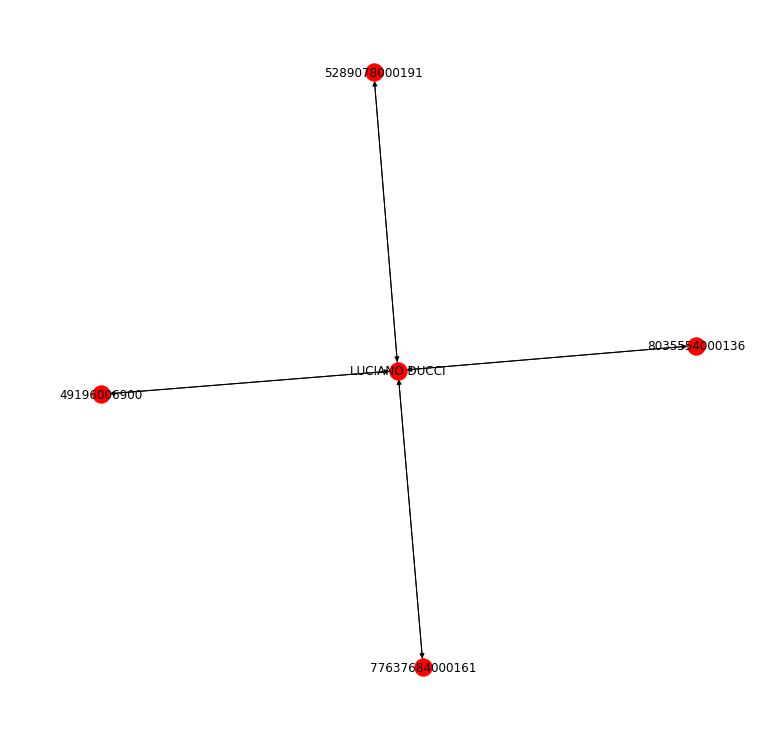

In [22]:
# 1.4.2.2. Plotando rede de ciclos diretos para um deputado específico
plt.rcParams.update({
    'figure.figsize': (10,10),
    'axes.spines.right': True,
    'axes.spines.left': True,
    'axes.spines.top': True,
    'axes.spines.bottom': True})
deputado = "LUCIANO DUCCI"
lista_subset_graph = list(df_ciclos_diretos[df_ciclos_diretos["3_nome_deputado"] == deputado]["1_id_empresa"]) + [deputado]
H = G.subgraph(lista_subset_graph)
nx.draw(H, style = "solid", with_labels = True)
plt.savefig("/home/gustavo/Downloads/Redes/Grafos/ciclos.png")  # save as png
plt.show()  # display

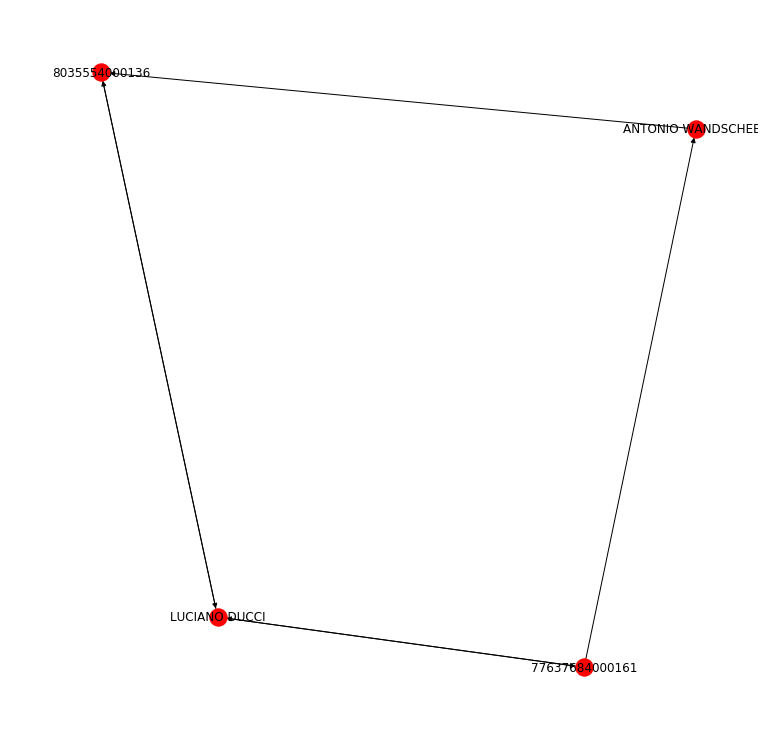

In [23]:
# 1.4.3. Plotando ciclos indiretos cruzados
ciclo_cruzado = df_ciclos_resumo[df_ciclos_resumo["tipo"] == "indireto cruzado"].iloc[0]["ciclo"]
H = G.subgraph(ciclo_cruzado)
nx.draw(H, style = "solid", with_labels = True)
plt.savefig("/home/gustavo/Downloads/Redes/Grafos/ciclos.png")  # save as png
plt.show()  # display


In [24]:
# 1.4.3.1. Criando tabela com resumo dos ciclos indiretos cruzados
lista_ciclos_cruzados = []
count = 0
for i in ciclos:
    if len(i) == 4:
        dict_i = {}
        if len(G.node[i[0]]) == 1:
            dict_i["1_id_empresa_a"] = i[0]
            dict_i["2_nome_empresa_a"] = G.node[i[0]]["nome_entidade"]
            dict_i["3_nome_deputado_x"] = i[1]
            dict_i["4_valor_doado_ax"] = G[i[0]][i[1]]["valor"]
            dict_i["5_qtde_doacoes_ax"] = G[i[0]][i[1]]["qtde"]
            dict_i["6_id_empresa_b"] = i[2]
            dict_i["7_nome_empresa_b"] = G.node[i[2]]["nome_entidade"]
            dict_i["8_valor_reembolsado_xb"] = G[i[1]][i[2]]["valor"]
            dict_i["9_qtde_reembolsos_xb"] = G[i[1]][i[2]]["qtde"]
            dict_i["10_nome_deputado_y"] = i[3]
            dict_i["11_valor_doado_by"] = G[i[2]][i[3]]["valor"]
            dict_i["12_qtde_doacoes_by"] = G[i[2]][i[3]]["qtde"]
            dict_i["13_valor_reembolsado_ya"] = G[i[3]][i[0]]["valor"]
            dict_i["14_qtde_reembolsos_ya"] = G[i[3]][i[0]]["qtde"]
        else:
            dict_i["1_id_empresa_a"] = i[3]
            dict_i["2_nome_empresa_a"] = G.node[i[3]]["nome_entidade"]
            dict_i["3_nome_deputado_x"] = i[0]
            dict_i["4_valor_doado_ax"] = G[i[3]][i[0]]["valor"]
            dict_i["5_qtde_doacoes_ax"] = G[i[3]][i[0]]["qtde"]
            dict_i["6_id_empresa_b"] = i[1]
            dict_i["7_nome_empresa_b"] = G.node[i[1]]["nome_entidade"]
            dict_i["8_valor_reembolsado_xb"] = G[i[0]][i[1]]["valor"]
            dict_i["9_qtde_reembolsos_xb"] = G[i[0]][i[1]]["qtde"]
            dict_i["10_nome_deputado_y"] = i[2]
            dict_i["11_valor_doado_by"] = G[i[1]][i[2]]["valor"]
            dict_i["12_qtde_doacoes_by"] = G[i[1]][i[2]]["qtde"]
            dict_i["13_valor_reembolsado_ya"] = G[i[2]][i[3]]["valor"]
            dict_i["14_qtde_reembolsos_ya"] = G[i[2]][i[3]]["qtde"]
        lista_ciclos_cruzados.append(dict_i)
    count += 1
    print(count)

df_ciclos_cruzados = pd.DataFrame(lista_ciclos_cruzados)
df_ciclos_cruzados.to_csv("/home/gustavo/Downloads/Redes/Tabelas_Gerada/df_ciclos_cruzados.csv")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [25]:
df_vinculos_reembolsos['id_empresa'] = df_vinculos_reembolsos['id_empresa'].apply(int)
df_vinculos_receitas['id_empresa'] = pd.to_numeric(df_vinculos_receitas['id_empresa'], errors='coerce')
df_vinculos_receitas = df_vinculos_receitas.dropna(subset=['id_empresa'])
df_vinculos_receitas['id_empresa'] = df_vinculos_receitas['id_empresa'].apply(int)

In [26]:
# 1.5. Criando tabela de resumo das empresas (Empresa, Doado, Reembolsado)


df_resumo_empresas_inner = pd.merge(df_vinculos_receitas.groupby(["id_empresa", "nome_empresa"]).agg({"valor": "sum"}).reset_index(), 
df_vinculos_reembolsos.groupby(["id_empresa"]).agg({"valor": "sum"}).reset_index(), on='id_empresa', how='inner')

df_resumo_empresas_inner.columns = ['id_empresa', 'nome_empresa', 'valor_doado', 'valor_reembolsado']

df_resumo_empresas_inner["percentual_de_retorno"] = 100 * (df_resumo_empresas_inner["valor_reembolsado"] - df_resumo_empresas_inner["valor_doado"])/df_resumo_empresas_inner["valor_doado"]


df_resumo_empresas_inner["percentual_de_retorno"] = df_resumo_empresas_inner["percentual_de_retorno"]
df_resumo_empresas_inner.to_csv("/home/gustavo/Downloads/Redes/Tabelas_Gerada/df_resumo_empresas_inner.csv")

df_resumo_empresas_left = pd.merge(df_vinculos_receitas.groupby(["id_empresa", "nome_empresa"]).agg({"valor": "sum", "nome_deputado": "count"}).reset_index(), df_vinculos_reembolsos.groupby(["id_empresa"]).agg({"valor": "sum", "nome_deputado": "count"}).reset_index(), on='id_empresa', how='left')
df_resumo_empresas_left.columns = ['id_empresa', 'nome_empresa', 'valor_doado',"qtde_deputados_recebedores", 'valor_reembolsado', "qtde_deputados_pagadores"]
df_resumo_empresas_left['valor_doado'].apply(float)

for i in ["valor_doado","qtde_deputados_recebedores","valor_reembolsado","qtde_deputados_pagadores"]:
    def escala(x):
        y =  round((x - df_resumo_empresas_left[i].min())/(df_resumo_empresas_left[i].max() - df_resumo_empresas_left[i].min()),6)
        return y
    nome_coluna_escala = (i + "_escala")
    df_resumo_empresas_left[nome_coluna_escala] = df_resumo_empresas_left[i].map(escala)
    print(i)

df_resumo_empresas_left["indice_de_influencia"] = df_resumo_empresas_left["valor_doado_escala"] + df_resumo_empresas_left["qtde_deputados_recebedores_escala"] + df_resumo_empresas_left["valor_reembolsado_escala"] + df_resumo_empresas_left["qtde_deputados_pagadores_escala"]
df_resumo_empresas_left.to_csv("/home/gustavo/Downloads/Redes/Tabelas_Gerada/df_resumo_empresas_left.csv")

valor_doado
qtde_deputados_recebedores
valor_reembolsado
qtde_deputados_pagadores


In [27]:
df_resumo_empresas_inner

id_empresa                                       nome_empresa  \
0        3777848930                        LUCIANO TADAU YAMAGUTI SATO   
1        4197917368                      YARA MARIA LIRA PAIVA E SILVA   
2        9636182884                             MAURICIO NUNES MARTINS   
3       17472415200                   CARLOS AUGUSTO LEMOS DE OLIVEIRA   
4       49196006900                                LOENI LUCIA DAL PRA   
5       71480625272                       JULIANA DOS SANTOS RODRIGUES   
6       83336532191                        MARCONES RIBEIRO DE  CASTRO   
7       97626000168                           BRASAL COMBUSTIVEIS LTDA   
8      110791000102                                IRMAOS MARINHO LTDA   
9      158540000106                 COP BEM GRAFICA E EDITORA LTDA EPP   
10     187214000119               POSTO DE COMBUSTIVEIS JAGUARIBE LTDA   
11     306597000105             CASCOL COMBUSTIVEIS PARA VEICULOS LTDA   
12     306597000105            CASCOL COMBUSTIVEIS PARA VEICULOS LTDA    
13     306597000105                  CASCOL COMBUSTIVEIS PARA VE�CULOS   
14     306597000105             CASCOL COMBUSTIVEIS PARA VE�CULOS LTDA   
15     306597000105              CASCOL COMBUSTIVEL PARA VEICULOS LTDA   
16     306597000105             CASCOL COMBUST�VEIS PARA VE�CULOS LTDA   
17     306597000105              CASCOL COMUSTIVEIS PARA VEICULOS LTDA   
18     313221000209                SERV CAR DERIVADOS DE PETR�LEO LTDA   
19     350242000105                                BENVENHO E CIA LTDA   
20     360990000179                        POSTO DE GASOLINA DOS ANOES   
21     376437000124                       AUTO POSTO ABEL GALINHA LTDA   
22     611875000120                              COMERCIAL RALORI LTDA   
23     613560000111    GLOBAL SOLUTIONS REPRESENTACOES COMERCIAIS LTDA   
24     672345000191                                 AUTO POSTO JB LTDA   
25     685464000189                         Dire��o Estadual/Distrital   
26     692418000107                              AUTO POSTO 5 ESTRELAS   
27     783707000111           EMPRESA JORNALISITICA ROTTA MARINGA LTDA   
28     817191000189                      GRAFICA E EDITORA UNIDOS LTDA   
29     961694000123                              VOGA COMUNICA��O LTDA   
..              ...                                                ...   
298  72820822000120                           SKY BRASIL SERVICOS LTDA   
299  72820822000120                           SKY BRASIL SERVI�OS LTDA   
300  72820822000120                          SKY BRASIL SERVI�OS LTDA.   
301  73413601000108  RODRIGUES TORRES COM E DERIVADOS DE PETROLEO LTDA   
302  73505349000230                   H2L EQUIPAMENTOS E SISTEMAS LTDA   
303  73783649000108       GRAFICA PRINT INDUSTRIA E EDITORIA LTDA - ME   
304  73787483000190                       PORTOS EMPREENDIMENTOS LTDA.   
305  77604163000108                     TUICIAL GRAFICA E EDITORA LTDA   
306  77637684000161                   COTRANS LOCACAO DE VEICULOS LTDA   
307  77637684000161                   COTRANS LOCA��O DE VEICULOS LTDA   
308  77637684000161                         COTRANS LOCA��O DE VE�CULO   
309  77637684000161                        COTRANS LOCA��O DE VE�CULOS   
310  77637684000161                   COTRANS LOCA��O DE VE�CULOS LTDA   
311  77637684000161                  COTRANS LOCA��O DE VE�CULOS LTDA.   
312  77867877000109                            RCK - COMUNICACOES LTDA   
313  79202719000165  RECANTO CATARATAS THERMAS CONVENTION & RESORT ...   
314  79552501000130                      JOAO GRANADO IMOBILI�RIA LTDA   
315  81124315000142                            FOQUESATTO & CIA. LTDA    
316  81584278000155                COOPERATIVA AGROINDUSTRIAL COPAGRIL   
317  82076977000157                    IMPREPEL GRAFICA E EDITORA LTDA   
318  83324921000137                          SUPER POSTO DOIS MIL LTDA   
319  84841931000102                 AJIR ARTES GRAFICAS E EDITORA LTDA   
320  87687489

In [28]:
def comunidade(i):
        
        if i < 0:
            return 'Mal investmento'
        elif i >=1 and i < 50:
            return 'Investimento mediano'
        elif i >= 50 and i <=100:
            return 'Bom investimento'
        elif i > 100 and i <=1000:
            return 'Ótimo investimento'
        elif i > 1000:
            return 'Excelente investimento'
        

df_resumo_empresas_inner['classificacao_roi'] = df_resumo_empresas_inner['percentual_de_retorno'].map(comunidade)


In [29]:
# 1.6. Criando tabela de resumo dos deputados (Empresa, Recebido, Reembolsado)
df_resumo_deputados_left = pd.merge(df_vinculos_receitas.groupby(["nome_deputado"]).agg({"valor": "sum", "id_empresa": pd.Series.nunique}).reset_index(), df_vinculos_reembolsos.groupby(["nome_deputado"]).agg({"valor": "sum", "id_empresa": pd.Series.nunique}).reset_index(), on='nome_deputado', how='left')
df_resumo_deputados_left.columns = ['nome_deputado', 'valor_recebido_doacoes', 'qtde_empresas_doadoras',"valor_pago_despesas", 'qtde_empresas_recebedoras']


for i in ["valor_recebido_doacoes","qtde_empresas_doadoras","valor_pago_despesas","qtde_empresas_recebedoras"]:
    def escala(x):
        y = float((x - df_resumo_deputados_left[i].min())/(df_resumo_deputados_left[i].max() - df_resumo_deputados_left[i].min()))
        return y
    nome_coluna_escala = (i + "_escala")
    df_resumo_dep/home/gustavo/Downloads/Redes/Tabelas_Gerada/utados_left[nome_coluna_escala] = df_resumo_deputados_left[i].map(escala)
    print(i)

df_resumo_deputados_left["indice_de_influencia"] = df_resumo_deputados_left["valor_recebido_doacoes_escala"] + df_resumo_deputados_left["qtde_empresas_doadoras_escala"] + df_resumo_deputados_left["valor_pago_despesas_escala"] + df_resumo_deputados_left["qtde_empresas_recebedoras_escala"]
df_resumo_deputados_left.to_csv("/home/gustavo/Downloads/Redes/Tabelas_Gerada/df_resumo_deputados_left.csv")

valor_recebido_doacoes
qtde_empresas_doadoras
valor_pago_despesas
qtde_empresas_recebedoras


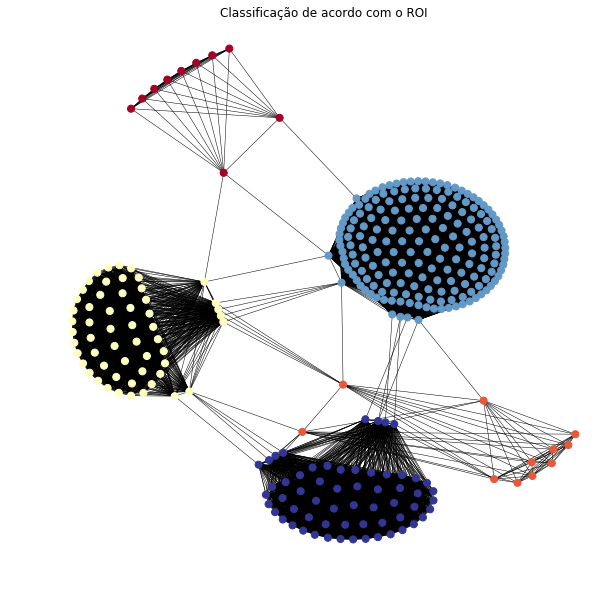

In [30]:
#2.0 Gerando grafos
#2.1 Rede representando a o retorno sobre o investimento
import itertools as it

G = nx.cubical_graph()
G.add_nodes_from([a for a in df_resumo_empresas_inner.index])
for ie in set(df_resumo_empresas_inner['id_empresa']):
    indices = df_resumo_empresas_inner[df_resumo_empresas_inner['id_empresa'] == ie].index
    G.add_edges_from(it.product(indices, indices))
    
for cr in set(df_resumo_empresas_inner['classificacao_roi']):
    indices = df_resumo_empresas_inner[df_resumo_empresas_inner['classificacao_roi']==cr].index
    G.add_edges_from(it.product(indices, indices))


plt.title('Classificação de acordo com o ROI')
color_mapping = {'Mal investmento': 250,
                 'Investimento mediano':50,
                 'Bom investimento':1,
                 'Ótimo investimento': 150,
                 'Excelente investimento': 300 }

#plt.figure(figsize=(7.5,7.5))
nx.draw(G,pos = nx.kamada_kawai_layout(G),node_size = 50, width = 0.5, 
        node_color=df_resumo_empresas_inner['classificacao_roi'].replace(color_mapping),with_labels=False,
        cmap='RdYlBu', vmin=0, vmax=300) 
plt.axis('off')
plt.savefig('ROI')
plt.show()

In [31]:
df_ciclos_diretos

1_id_empresa                                     2_nome_empresa  \
0   13524791000109                                     JL Consultores   
1    4707821000113        SOJA COMERCIO DE DERIVADOS DE PETROLEO LTDA   
2   20629347000105                STAR TUR VIAGENS E TURISMO LTDA-EPP   
3   11601349000103                  E.M COMERCIO DE COMBUSTIVEIS LTDA   
4   24186785000105              SOMAPETRO COMERCIO E TRANSPORTES LTDA   
5   12053850000137                                     GRAAL OURINHOS   
6   87687489000108                 POSTO DE COMBUSTIVEIS VACCARI LTDA   
7   84841931000102           AJIR ARTES GRAFICAS E EDITORA LTDA - EPP   
8       4197917368                      YARA MARIA LIRA PAIVA E SILVA   
9      83336532191                         Marcones Ribeiro de Castro   
10  44273563000129                             AUTO POSTO THIANE LTDA   
11   3215139000140                        SUPERA COMUNICAÇÃO S/C LTDA   
12  57534679000116                      NOVA FREITAS IMÓVEIS - MATRIZ   
13   4393926000145      SMS SEGURANÇA E MONITORAMENTO E SERVIÇOS LTDA   
14  12474349000144                K SOLUCÕES E LOGISTICA EIRELI - EPP   
15  28271195000123              Posto de Abast de Comb Vila Nova Ltda   
16   4929683000117                              DELTA PUBLICIDADE S/A   
17   4929683000117                              DELTA PUBLICIDADE S/A   
18   5990032000103                              POSTO BRASIL LTDA EPP   
19   3006726000120          Auto Posto Piloto Marcelle Locatelli Ltda   
20   5964723000124                     LUBE COMERCIO DE PETROLEO LTDA   
21  23121478000256                                POSTO PARAENSE LTDA   
22   1487047000194                                             UNIDAS   
23   7272825000457  Ibyte Tecno Indústria e Comércio de Computador...   
24    611875000120                              COMERCIAL RALORI LTDA   
25  20110680000103                            Grafica Mundial LTDA-ME   
26  14028926000108              TROIA COMUNICAÇÃO INTEGRADA LTDA - ME   
27  54450705000130                                GRÁFICA TRÊS PONTAS   
28   2444277000139                    ARTGRAPH SERVIÇOS GRAFICOS LTDA   
29  72820822000120                           SKY BRASIL SERVIÇOS LTDA   
..             ...                                                ...   
32   4202351000136                             AUTO POSTO CANAAN LTDA   
33  82076977000157              Imprepel-Grafica & Editora Ltda - Epp   
34  77637684000161                  COTRANS LOCAÇÃO DE VEÍCULOS LTDA.   
35   1059928000104                             AUTO POSTO NUELE LTDA.   
36   8707885000175                          JORNAL A SEMANA LTDA - ME   
37   8035554000136                      POSTO CAMINHO DO PARQUE LTDA.   
38   5289078000191                            POSTO CANAL ALPHA LTDA.   
39     49196006900                                LEONI LUCIA DAL-PRÁ   
40   7027856000108                       Noschang Artes Graficas Ltda   
41   2471339000100         Quatro Estacoes Industria Grafica Ltda EPP   
42    613560000111    GLOBAL SOLUTIONS REPRESENTAÇÕES COMERCIAIS LTDA   
43   1518155000187         LAPA DIST. DE COMB E DERIVADOS DE PETRÓLEO   
44   3090756000167                        AMAZONAVES TAXI AÉREO LTDA.   
45  37034014000136                     GRECO COMÉRCIO DE FRANGOS LTDA   
46  19507939000175                         W V DIAS COMBUSTIVEIS LTDA   
47  10763573000120  Afixar - Desenvolvimento Web e Design Ltda ME ...   
48   3702790000145                 Barcelos Papelaria e Livraria Ltda   
49  11786457000190     POSTO Z+Z NOSSA SENHORA MEDALHA MILAGROSA LTDA   
50  17482365000100                                  EDITORA FAPI LTDA   
51  26198515000484                               SEMPRE EDITORA LTDA.   
52  15739283000165              VIDA NOVA LIVRARIA E PAPELARIA EIRELI   
53  26198515000484                               SEMPRE EDITORA LTDA.   
54   3282708000170                                  POUSADA SAN 

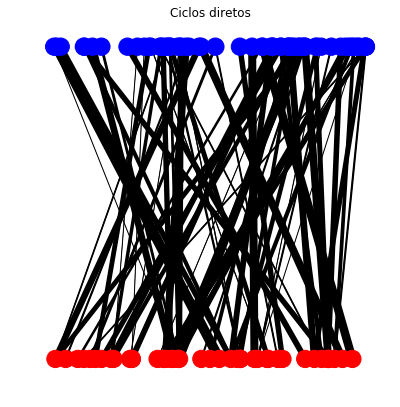

In [32]:
import random
import numpy as np

G = nx.Graph()
G.add_nodes_from(df_ciclos_diretos['1_id_empresa'], type_='1_id_empresa')
for node in G.nodes:
    G.nodes[node]['2_nome_empresa'] = df_ciclos_diretos[df_ciclos_diretos['1_id_empresa'] == node]['2_nome_empresa'].values[0]
    
G.add_nodes_from(df_ciclos_diretos['3_nome_deputado'], type_='3_nome_deputado')

df_ciclos_diretos['peso'] = df_ciclos_diretos['8_percentual_retorno'].apply(
lambda x: round(np.log(x),3))

G.add_weighted_edges_from(df_ciclos_diretos[['1_id_empresa', '3_nome_deputado', 'peso']].values)


colors = ['#0000FF' if G.nodes[n]['type_'] == '1_id_empresa' else '#FF0000' for n in G.nodes]
pos = {
    n: (
        random.random(),
        1 if G.nodes[n]['type_'] == '1_id_empresa' else 0,
    )
    for n in G.nodes

}

weigthed_pos = nx.spring_layout(G, pos=pos)
edge_width = [a[2]['weight'] for a in G.edges(data=True)]

plt.figure(figsize=(5,5))

nx.draw(G, pos = pos, node_color=colors, with_labels=False, edge_cmap=plt.cm.Blues,)
nx.draw_networkx_edges(G, pos=pos,width=edge_width)
plt.title('Ciclos diretos')
plt.axis('off')
plt.savefig('/home/gustavo/Downloads/Redes/Grafos/Ciclos diretos.png')
#plt.show()
#G.edges[(13524791000109, 'DIONILSO MATEUS MARCON')]

In [74]:
df_ciclos_diretos

1_id_empresa                                     2_nome_empresa  \
0   13524791000109                                     JL Consultores   
1   12053850000137                                     GRAAL OURINHOS   
2   11601349000103                  E.M COMERCIO DE COMBUSTIVEIS LTDA   
3    4707821000113        SOJA COMERCIO DE DERIVADOS DE PETROLEO LTDA   
4   20629347000105                STAR TUR VIAGENS E TURISMO LTDA-EPP   
5   87687489000108                 POSTO DE COMBUSTIVEIS VACCARI LTDA   
6   84841931000102           AJIR ARTES GRAFICAS E EDITORA LTDA - EPP   
7       4197917368                      YARA MARIA LIRA PAIVA E SILVA   
8      83336532191                         Marcones Ribeiro de Castro   
9   44273563000129                             AUTO POSTO THIANE LTDA   
10   3215139000140                      SUPERA COMUNICAÃÃO S/C LTDA   
11  57534679000116                     NOVA FREITAS IMÃVEIS - MATRIZ   
12  12474349000144               K SOLUCÃES E LOGISTICA EIRELI - EPP   
13   4393926000145    SMS SEGURANÃA E MONITORAMENTO E SERVIÃOS LTDA   
14  28271195000123     POSTO DE ABASTECIMENTO DE COMB. VILA NOVA LTDA   
15   4929683000117                              DELTA PUBLICIDADE S/A   
16   4929683000117                              DELTA PUBLICIDADE S/A   
17   5990032000103                                  POSTO BRASIL LTDA   
18   3006726000120          Auto Posto Piloto Marcelle Locatelli Ltda   
19   5964723000124                     LUBE COMERCIO DE PETROLEO LTDA   
20   1487047000194             LOCARFÃCIL LOCADORA DE VEÃCULOS LTDA   
21   7272825000457  Ibyte Tecno IndÃºstria e ComÃ©rcio de Computad...   
22    611875000120                              COMERCIAL RALORI LTDA   
23  20110680000103                            Grafica Mundial LTDA-ME   
24  14028926000108            TROIA COMUNICAÃÃO INTEGRADA LTDA - ME   
25  54450705000130                              GRÃFICA TRÃS PONTAS   
26   2444277000139                   ARTGRAPH SERVIÃOS GRAFICOS LTDA   
27  72820822000120                          SKY BRASIL SERVIÃOS LTDA   
28      3777848930                                      Fabio Antonio   
29   9553867000149                             IMAM WEB SISTEMAS LTDA   
30   4202351000136                             AUTO POSTO CANAAN LTDA   
31  82076977000157              Imprepel-Grafica & Editora Ltda - Epp   
32  77637684000161               COTRANS LOCAÃÃO DE VEÃCULOS LTDA.   
33   1059928000104                             AUTO POSTO NUELE LTDA.   
34   8707885000175                          JORNAL A SEMANA LTDA - ME   
35   8035554000136                      POSTO CAMINHO DO PARQUE LTDA.   
36     49196006900                               LEONI LUCIA DAL-PRÃ   
37   5289078000191                            POSTO CANAL ALPHA LTDA.   
38   7027856000108                       NOSCHANG ARTES GRAFICAS LTDA   
39    613560000111  GLOBAL SOLUTIONS REPRESENTAÃÃES COMERCIAIS LTDA   
40   1518155000187        LAPA DIST. DE COMB E DERIVADOS DE PETRÃLEO   
41   3090756000167                       AMAZONAVES TAXI AÃREO LTDA.   
42  37034014000136                    GRECO COMÃRCIO DE FRANGOS LTDA   
43  10763573000120  Afixar - Desenvolvimento Web e Design Ltda ME ...   
44   3702790000145                 Barcelos Papelaria e Livraria Ltda   
45  11786457000190     POSTO Z+Z NOSSA SENHORA MEDALHA MILAGROSA LTDA   
46  17482365000100                                  EDITORA FAPI LTDA   
47  26198515000484                               SEMPRE EDITORA LTDA.   
48  26198515000484                               SEMPRE EDITORA LTDA.   
49  15739283000165              VIDA NOVA LIVRARIA E PAPELARIA EIRELI   
50   3282708000170                                  POUSADA SAN MARCO   
51  21652672000151                       TARGET RENT A CAR LTDA - EPP   
52   7263666000181                    BRASPOR GRAFICA E EDITORA LTDA.   
53   6985134000195    PETROCOM-COM.DE COMB. E DERIV. DE PETROLEO

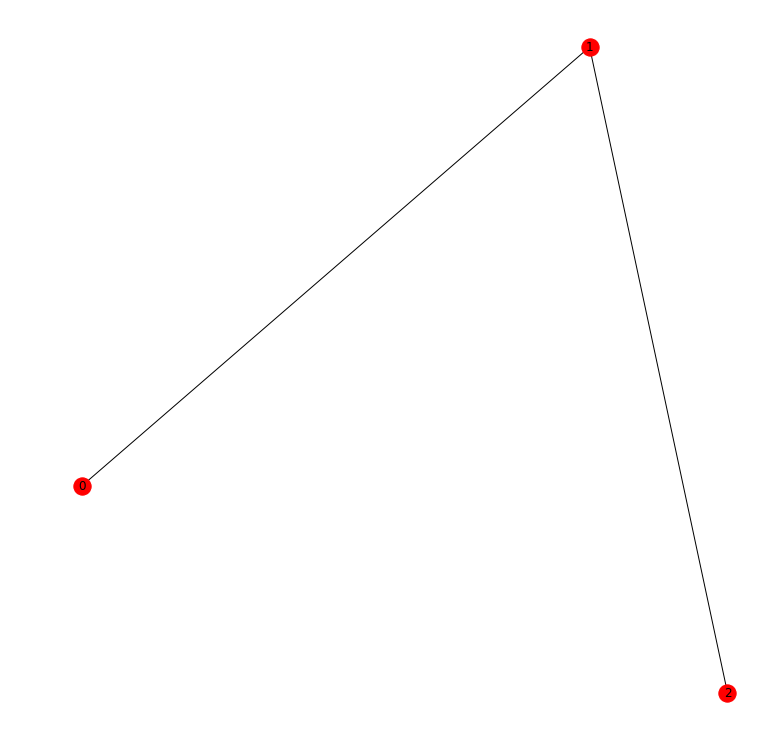

In [33]:
G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_weighted_edges_from([(0,1,3.0),(1,2,7.5)])
nx.draw(G, pos=nx.spectral_layout(G), with_labels=True)

In [34]:
############ Gerando grafo em d3 para visualizar em HTML ###############
# Neste caso é necessátio utilizar o arquivo HTML de template

import json
import os
import re

# montar dicionario de nós e arestas
deputado = "LUCIANO DUCCI"
lista_subset_graph = list(df_ciclos_diretos[df_ciclos_diretos["3_nome_deputado"] == deputado]["1_id_empresa"]) + [deputado]
H = G.subgraph(lista_subset_graph)

json_txt = dict()
json_txt["nodes"] = []
json_txt["links"] = []

for i in lista_subset_graph:
    dict_i = {}
    dict_i["id"] = str(i)
    dict_i["group"] = str(1)
    dict_i["size"] = str(3)
    json_txt["nodes"].append(dict_i)

for j in H.edges():
    dict_j = {}
    dict_j["source"] = str(j[0])
    dict_j["target"] = str(j[1])
    dict_j["value"] = str(H[j[0]][j[1]]["valor"])
    json_txt["links"].append(dict_j)


html = ''
with open(os.path.join('visualizar_grafo_template.html'), 'r', encoding='utf-8') as arq:
    html = ''.join(arq.readlines())

path_html_final = os.path.join('visualizar_grafo.html')
with open(path_html_final, 'w', encoding='utf-8') as arq:
    json_str = json.dumps(json_txt)
    html = re.sub('"{{json_data}}"', json_str, html)
    arq.write(html)

import webbrowser
webbrowser.open('file://' + os.path.realpath(path_html_final))

######################

True